# Module 4 Project
* Student name: Bronwen C.
* Student pace: Self-paced
* Scheduled project review date/time: March 4, 11:00 EST
* Instructor name: Jeff
* Blog post URL: https://bronwencc.github.io/module_4_final_project

## Objective:
This notebook intends to select five areas from the Zillow dataset to recommend as the best real estate markets in which to invest.  It determines p, d, and q parameters from modeling a time series of an overall average and choosing those with the lowest AIC and resulted in terms' p-values under 0.05.  Those parameters are then used to model the median ninth (44th to 55th percentiles based on the prices for the last recorded date) of the data to narrow down the best 20 that have the lowest mean-squared error when matching the first five steps of forecasts using the training set to the correspondingly first five values of the test set.  With those 20, predictions for 2 years into the future were made (24 steps ahead) and confidence interval bounds were determined.  When comparing the lower bound of the last date to the last observed value for them, the five that had the highest percent change (in this case, the negative numbers closest to zero) were said to be the top five regions in which to invest.

In [ ]:
#all import statements at beginning
import statsmodels.api as sm
import math
import time
import pandas as pd

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")

In [ ]:
import itertools

In [24]:
#creating folder for files and images
import os

current = os.curdir
newfolder = 'files'
newpath = os.path.join(current,newfolder)
if not os.path.exists(newpath):
    os.makedirs(newpath)

# 1: Load and Explore Data
Find null values, look at shape and description.

In [11]:
data = pd.read_csv("zillow_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
#checking for null/missing values in data
data.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
              ... 
2015-11          0
2015-12          0
2016-01          0
2016-02          0
2016-03          0
2016-04          0
2016-05          0
2016-06          0
2016-07          0
2016-08          0
2016-09          0
2016-10          0
2016-11          0
2016-12          0
2017-01          0
2017-02          0
2017-03          0
2017-04          0
2017-05          0
2017-06          0
2017-07          0
2017-08     

The data is missing only 1039 values out of 14723 records so I will look at it transposed to compare the values missing and drop them.

In [33]:
#this function takes the columns of the dataframe that have dates and returns them as a DateTime series
def get_datetimes(df):
    '''
    For a dataframe with the eighth column name onwards in the Year-month format.
    
    Args
        df (pandas DataFrame): a dataframe with the eighth column title and subsequent names in the format of Year-month
    
    Returns
        (pandas DateTime Series): a pandas DateTime object of those selected column names (e.g., 1980-5 becomes 1980-05-01)
    '''
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [29]:
#checking how many unique RegionID's are in data
len(data.RegionID.value_counts())

14723

In [30]:
#comparing how many records are in the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


There are 14723 entries in the dataframe and 14723 RegionID's so each RegionID must be unique.

In [32]:
#function to convert selection of dataframe into a dictionary to become transposed and have months as the index
def transposeDF(dataframe):
    '''
    Transposes dataframe to make a new one purely of prices data with RegionID's as column titles and dates as the index.
    
    Args
        dataframe (pandas DataFrame): a DataFrame with the expected transposed column names in the first column and the relevant information in the eighth column onwards and dates of Year-month format in those same columns' titles.
    
    Returns
        (pandas DataFrame): a DataFrame with the column titles from dataframe's first column and the index of DateTime objects from its eighth until its last column names
    '''
    
    #transpose dataframe into matrix of prices and DateTimeIndex
    thislist = [list(row) for row in dataframe.iloc[:,7:].values]
    
    #putting the dates into a datetime format
    times = get_datetimes(dataframe)

    thisdict = dict()
    #converting the list into a dictionary
    for idx, each in enumerate(thislist):
        regionID = dataframe.iloc[idx,0] #0 is where the RegionID is
        thisdict[regionID]=each #add it to a dictionary with RegionID as the key
 
    return pd.DataFrame(data=thisdict, index=times)#with a dictionary, each key-value pair becomes a column name and column of data, respectively

In [37]:
pricedf = transposeDF(data)
pricedf.head()

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [40]:
#drop columns with missing data:
pricedf.dropna(axis=1, inplace=True)
pricedf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Columns: 13684 entries, 84654 to 95851
dtypes: float64(13684)
memory usage: 27.7 MB


In [41]:
#save the prices/dates-only transposed version of the dataframe
pricedf.to_csv("files/transposedPrices.csv")

# Step 2: Data Preprocessing

In [31]:
def melt_data(df):
    '''
    Taking the Zillow DataFrame's column names with dates to make a DateTimeIndex and the averaged prices for each date.
    
    Args
        df (pandas DataFrame): a DataFrame with dates and descriptive properties in the column names
        
    Returns
        (pandas DataFrame): a DataFrame with a DateTimeIndex "time" and one column titled "value", which is an average of the prices for that corresponding date
    '''
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Without dealing with the missing values in certain dates and the Metro information, I will melt the data into a timeseries of the averages for each date.  Null values would not be included in the average.

In [6]:
avgtseries = melt_data(data)
avgtseries.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


# Step 3: EDA and Visualization

In [82]:
#split into train-test sets 70/30 split
trainsize = int(len(avgtseries)*.7)
atrain = avgtseries[0:trainsize]
atest = avgtseries[trainsize:]

In [83]:
atrain.tail()

,value
time,
2011-04-01,204642.594131
2011-05-01,204012.631506
2011-06-01,203430.571705
2011-07-01,202726.976230
2011-08-01,202212.493090


I'll look at the ACF and PACF plots for the timeseries averages.

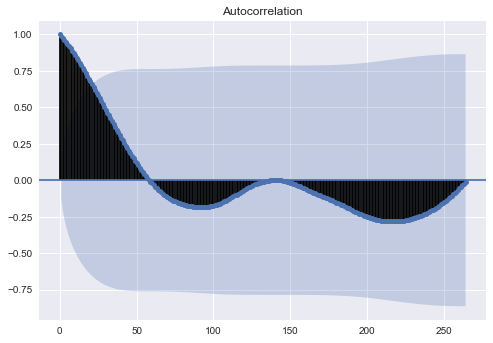

In [85]:
fig1 = plot_acf(avgtseries)

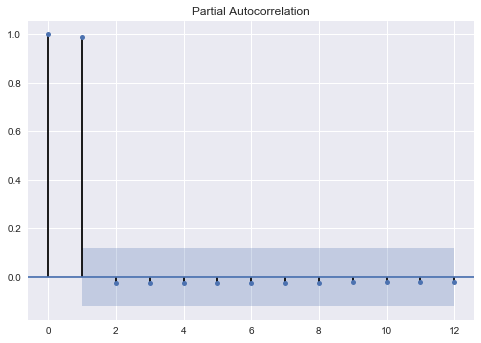

In [86]:
fig2 = plot_pacf(avgtseries,lags=12,method='ywm')

The PACF plot shows a spike at 1, so the order is 1.

# Step 4: ARIMA Modeling

In [87]:
p=range(0,2)
d=range(0,3)
q=range(0,3)

#generating combinations of p, q and q triplets
tempdq = list(itertools.product(p, d, q))

In [75]:
pdq=[]
#only want where p = 1 since the PACF and ACF plots had order 1
for each in tempdq:
    if each[0]==1:
        pdq.append(each)

In earlier iterations of this notebook, I tested with varying values for periodicity: 3 and 9, but neither had lower AIC's than the results that using 12 gave.

In [76]:
#generating seasonal p, q and q triplets (12 for a 12-month cycle)
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [89]:
#looping through each possible combination of the p,d,q values
comb12results = []
for comb in pdq:
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(atrain, order=comb, seasonal_order=combs, enforce_stationarity=False, enforce_invertibility=False, freq='MS')
            output = model.fit()
            comb12results.append([comb, combs, output.aic])
            print('ARIMA {} x {} : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (1, 0, 0) x (1, 0, 0, 12) : AIC Calculated =2809.954854184663
ARIMA (1, 0, 0) x (1, 0, 1, 12) : AIC Calculated =2837.686821287981


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 2, 12) : AIC Calculated =2667.004656072996
ARIMA (1, 0, 0) x (1, 1, 0, 12) : AIC Calculated =2625.351488885406
ARIMA (1, 0, 0) x (1, 1, 1, 12) : AIC Calculated =2624.2767478247806
ARIMA (1, 0, 0) x (1, 1, 2, 12) : AIC Calculated =2439.1771813723735
ARIMA (1, 0, 0) x (1, 2, 0, 12) : AIC Calculated =2497.2784119273747
ARIMA (1, 0, 0) x (1, 2, 1, 12) : AIC Calculated =2499.22182200503
ARIMA (1, 0, 0) x (1, 2, 2, 12) : AIC Calculated =2277.9479901602
ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated =2859.9658533107768
ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated =2820.1715563956705


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 2, 12) : AIC Calculated =2622.2195451318767
ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated =2556.360635715646
ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated =2542.1740226634747


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 2, 12) : AIC Calculated =2358.4888644212488


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 2, 0, 12) : AIC Calculated =2436.7428120747513
ARIMA (1, 0, 1) x (1, 2, 1, 12) : AIC Calculated =2525.5819077119904
ARIMA (1, 0, 1) x (1, 2, 2, 12) : AIC Calculated =2298.491509394667
ARIMA (1, 0, 2) x (1, 0, 0, 12) : AIC Calculated =2860.628628929425


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 0, 1, 12) : AIC Calculated =2789.0512902819855


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 0, 2, 12) : AIC Calculated =2653.644033981497
ARIMA (1, 0, 2) x (1, 1, 0, 12) : AIC Calculated =2485.0102772874725


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 1, 1, 12) : AIC Calculated =2495.2542982134796


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 2) x (1, 1, 2, 12) : AIC Calculated =2312.7144224170243
ARIMA (1, 0, 2) x (1, 2, 0, 12) : AIC Calculated =2404.8034011352856
ARIMA (1, 0, 2) x (1, 2, 1, 12) : AIC Calculated =2508.1746771374055
ARIMA (1, 0, 2) x (1, 2, 2, 12) : AIC Calculated =2284.071254083679
ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated =2478.0686065005043
ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated =2480.046036711026
ARIMA (1, 1, 0) x (1, 0, 2, 12) : AIC Calculated =2318.186676133754
ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated =2365.918897137266
ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC Calculated =2367.441007798078
ARIMA (1, 1, 0) x (1, 1, 2, 12) : AIC Calculated =2171.1592022109417
ARIMA (1, 1, 0) x (1, 2, 0, 12) : AIC Calculated =2301.965051514725
ARIMA (1, 1, 0) x (1, 2, 1, 12) : AIC Calculated =2302.4555487102252
ARIMA (1, 1, 0) x (1, 2, 2, 12) : AIC Calculated =2112.0751243892682
ARIMA (1, 1, 1) x (1, 0, 0, 12) : AIC Calculated =2465.1895030922365
ARIMA (1, 1, 1) x (1, 0, 1, 12) : AIC Ca

C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (1, 2, 2, 12) : AIC Calculated =2104.2961222718004
ARIMA (1, 2, 1) x (1, 0, 0, 12) : AIC Calculated =2452.272048089181
ARIMA (1, 2, 1) x (1, 0, 1, 12) : AIC Calculated =2440.6227832020777
ARIMA (1, 2, 1) x (1, 0, 2, 12) : AIC Calculated =2278.2733363772177
ARIMA (1, 2, 1) x (1, 1, 0, 12) : AIC Calculated =2346.8118931681365
ARIMA (1, 2, 1) x (1, 1, 1, 12) : AIC Calculated =2297.9006473094123
ARIMA (1, 2, 1) x (1, 1, 2, 12) : AIC Calculated =2132.7198665275964
ARIMA (1, 2, 1) x (1, 2, 0, 12) : AIC Calculated =2282.7406460650227
ARIMA (1, 2, 1) x (1, 2, 1, 12) : AIC Calculated =2268.2790217594656


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (1, 2, 2, 12) : AIC Calculated =2021.0149690024718
ARIMA (1, 2, 2) x (1, 0, 0, 12) : AIC Calculated =2453.483281740514
ARIMA (1, 2, 2) x (1, 0, 1, 12) : AIC Calculated =2428.270169551583
ARIMA (1, 2, 2) x (1, 0, 2, 12) : AIC Calculated =2266.227468074647
ARIMA (1, 2, 2) x (1, 1, 0, 12) : AIC Calculated =2348.616283194857
ARIMA (1, 2, 2) x (1, 1, 1, 12) : AIC Calculated =2283.1866716454533
ARIMA (1, 2, 2) x (1, 1, 2, 12) : AIC Calculated =2121.0881009256973
ARIMA (1, 2, 2) x (1, 2, 0, 12) : AIC Calculated =2284.502510832387


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 1, 12) : AIC Calculated =2255.0822350509225


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12) : AIC Calculated =1999.8189387395562


In [90]:
combresdf12 = pd.DataFrame(comb12results, columns=['pdq', 'pdqs', 'aic'])

In [91]:
combresdf12.loc[combresdf12['aic'].idxmin()]

pdq         (1, 2, 2)
pdqs    (1, 2, 2, 12)
aic           1999.82
Name: 80, dtype: object

In [92]:
best12pdq=combresdf12.loc[combresdf12['aic'].idxmin()].pdq
best12pdqs=combresdf12.loc[combresdf12['aic'].idxmin()].pdqs

In [93]:
#save model with these values:
best12model = sm.tsa.statespace.SARIMAX(atrain,order=best12pdq,seasonal_order=best12pdqs,enforce_stationarity=False,enforce_invertibility=False)

#fit model
best12output = best12model.fit()

#print summary table of coefficients
print(best12output.summary().tables[1])

C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4536      0.114     -3.965      0.000      -0.678      -0.229
ma.L1          0.1702      0.108      1.582      0.114      -0.041       0.381
ma.L2         -0.0384      0.067     -0.570      0.569      -0.170       0.094
ar.S.L12       0.1825      0.027      6.732      0.000       0.129       0.236
ma.S.L12      -1.8001      0.184     -9.807      0.000      -2.160      -1.440
ma.S.L24       0.8541      0.115      7.411      0.000       0.628       1.080
sigma2      1.375e+05   2.85e+04      4.819      0.000    8.16e+04    1.93e+05


For the time-series, five weights ($P>|z|$) have a p-value less than 0.05, (ar.L1, ar.S.L12, ma.S.L12, ma.S.L24, and sigma2) so I retain these in the model.  To remove ma.L1 and ma.L2, I set q to 0 in the non-seasonal order, meaning I use (1,2,0) for `order` and (1,2,2,12) for `seasonal_order` which previously was found to have the slightly higher AIC of ~2104.

In [62]:
#removing the following from the model: ["ma.L1", "ma.L2"]
bestpdq=(1,2,0) #using 1,2,2 from earlier, with q as 0 since q contains ma.L1 and ma.L2
bestpdqs=(1,2,2,12) #using 1,2,2,12 from before

bestmodel = sm.tsa.statespace.SARIMAX(atrain,order=bestpdq,
                                      seasonal_order=bestpdqs,
                                      enforce_stationarity=False,enforce_invertibility=False, freq='MS')

#fit model
bestoutput = bestmodel.fit()

#print summary table of coefficients
print(bestoutput.summary().tables[1])

C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1742      0.043     -4.031      0.000      -0.259      -0.090
ar.S.L12       0.6059      0.017     35.644      0.000       0.573       0.639
ma.S.L12      -2.3114      0.095    -24.227      0.000      -2.498      -2.124
ma.S.L24       1.3633      0.140      9.766      0.000       1.090       1.637
sigma2      1.121e+05    1.3e+04      8.591      0.000    8.65e+04    1.38e+05


This model does not have any $P>|z|$ values that are greater than 0.05.

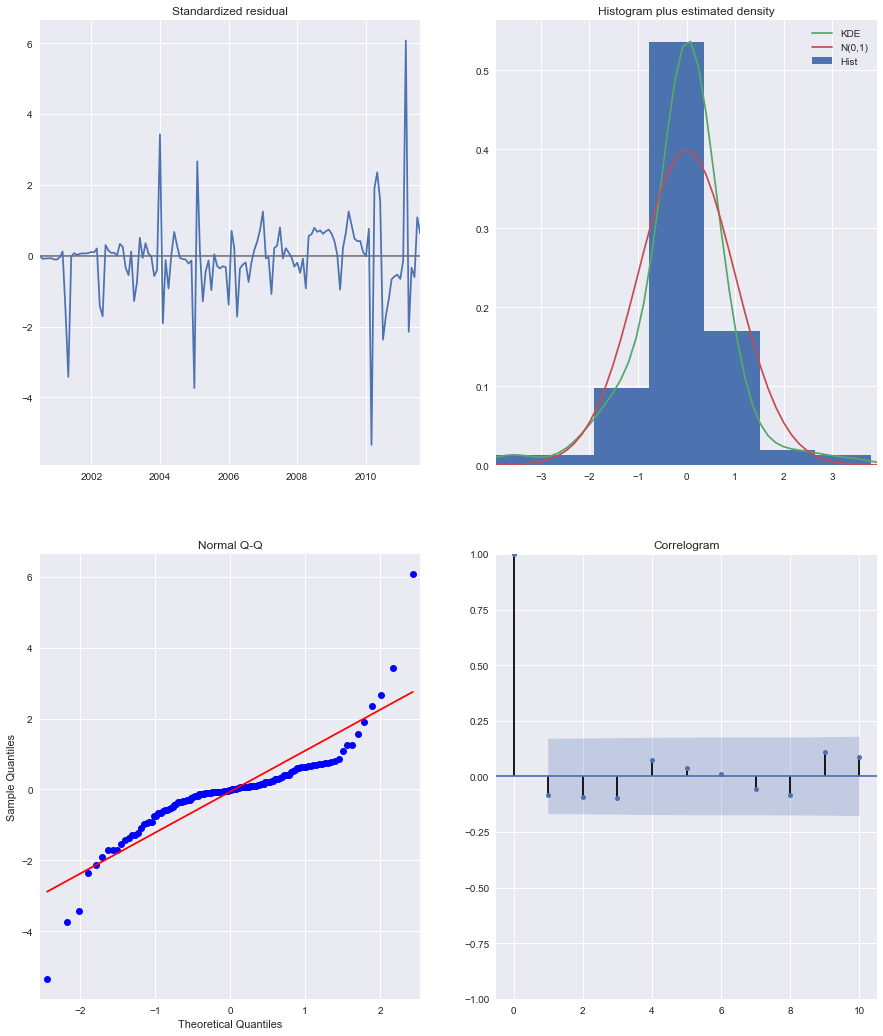

In [63]:
bestoutput.plot_diagnostics(figsize=(15, 18))
plt.show()

From top left, clockwise:
1. The residuals over time have a slight cyclical behavior, such that they do not appear to be purely white noise.
2. The KDE and N(0,1) lines match fairly closely though the KDE has a sharper peak.
3. The Correlogram shows residuals have little correlation with lagged versions of the time series so it shows some seasonality in cycles of 3.
4. The Q-Q plot shows the residuals are a little different from a normal distribution; forming more of a wave than a line.

### Creating Visuals of `avgtseries`
I will take an aside to create a graph of the `avgtseries` and its predicted values until April 2020 for the accompanying PowerPoint presentation.

In [98]:
#creating a model to get forecasts for 24 steps ahead of 2018-04 by month
bestmodel = sm.tsa.statespace.SARIMAX(avgtseries,order=bestpdq,
                                      seasonal_order=bestpdqs,
                                      enforce_stationarity=False,enforce_invertibility=False, freq='MS')
#fit model
bestoutput = bestmodel.fit()

bestcast = bestoutput.forecast(24)

In [102]:
#getting the confidence intervals for the predictions
predictions = bestoutput.get_prediction(start=pd.to_datetime("2018-05-01"), end=pd.to_datetime("2020-04-01"))
confid_int = predictions.conf_int()
confintdf = pd.DataFrame(confid_int, index=pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS'))

In [103]:
confintdf.head()

,lower value,upper value
2018-05-01,289211.731147,290559.470890
2018-06-01,290261.195417,293141.943222
2018-07-01,291080.722976,295818.145065
2018-08-01,291770.696001,298639.707892
2018-09-01,292351.803505,301596.510759


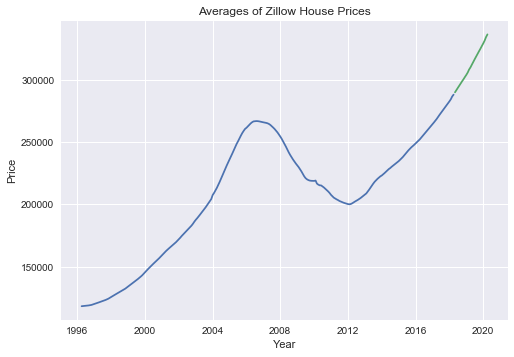

In [101]:
#graphing forecasted values and the original overall average
plt.plot(avgtseries, label="actual")
plt.plot(bestcast, label="forecast")
plt.title("Average of Zillow House Prices")
plt.ylabel("Price")
plt.xlabel("Year")
plt.show()

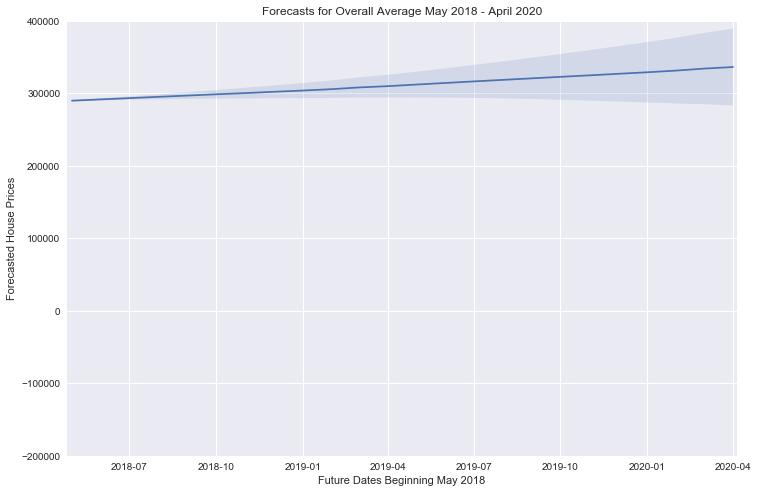

In [104]:
#graphing only the forecasted values on the same scale as the selected 20 RegionID's
fig = plt.figure(figsize = (12, 8))

plt.plot(bestcast)
plt.fill_between(confintdf.index, confintdf["lower value"], confintdf["upper value"], alpha=.15)

plt.ylim(bottom=-200000)
plt.ylim(top=400000)
plt.xlim(left=736809.95)#if 736779.95 is a little before 2018-05, then adding 30 would almost put the beginning on the y-axis
plt.xlim(right=737520.05)#similar to above for 2020-04
plt.title("Forecasts for Overall Average May 2018 - April 2020")
plt.ylabel("Forecasted House Prices")
plt.xlabel("Future Dates Beginning May 2018")
plt.savefig("files/Average Forecast.png")
plt.show()

## Choosing Data to Model from `pricedf`
I will now consider the data in the `pricedf`, by modeling each column with the `pdq` values used in `bestmodel` in a SARIMAX model, separated by train and test splits of the `trainsize` 80%-20%.  Once using the train set to make predictions, they will be compared to the test set and the mean-squared error from that can be stored along with the zip code (column name) in a dictionary.

As it seems the amount of time that would be needed to find the mean-squared error for any small amount of forecasting (5 or fewer steps) for each RegionID is still at about 29 or 28 hours, I will cut down pricedf by two-thirds using a different criteria.

In [135]:
#a method to use SARIMAX, fit the model, and calculate a mean-squared error comparing predictions and test set
def eval_model(tseries,combo,combos,size,castnum=5):
    '''
    Takes in a time Series and calculates the mean-squared error for the training size's 5-step (or given number) ahead predictions made with statsmodels' SARIMAX compared with those same first (5) steps of the test set.
    
    Args
        tseries (pandas Series): a Series with an index of DateTime in date order
        combo (list or array-like of integers): the p, d, q values for the SARIMAX "order" parameter
        combos (list or array-like of integers): the P, D, Q and periodicity values for the SARIMAX seasonal_order parameter
        size (integer): value at which to split tseries into train (up until that index) and test (from that index until the end) sets
        castnum (integer): number of steps ahead to predict using the train set and then compare with the test set, default is 5
        
    Returns
        msqerr (float): the mean-squared error of the castnum steps predicted compared to those actual values for those dates in the test set, this value is also printed 
    '''
    train = tseries[:size]
    test = tseries[size:]
    
    model = sm.tsa.statespace.SARIMAX(train, order=combo, seasonal_order=combos, enforce_stationarity=False,enforce_invertibility=False, freq='MS')
    # fit model
    output = model.fit(disp=0,cov_type="approx",low_memory=True)#hopefully reducing the amount of memory will reduce the amount of time
    cast = output.forecast(castnum)

    preds = []
    for i in range(castnum):
        yhat = cast[i]
        #add predicted value to preds
        preds.append(yhat)
    
    test=[t for t in test[:castnum]]
    sqerror = [(t-p)**2 for t,p in zip(test,preds)]
    msqerr = np.mean(sqerror)
    print(msqerr)
    return msqerr

In [3]:
pricedf = pd.read_csv("files/transposedPrices.csv")
pricedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Columns: 13685 entries, Unnamed: 0 to 95851
dtypes: float64(13684), object(1)
memory usage: 27.7+ MB


In [9]:
#making sure the DataFrame has an appropriate DateTimeIndex
pricedf["time"]=pd.to_datetime(pricedf["Unnamed: 0"])
pricedf.set_index(pricedf["time"], inplace=True)
pricedf.drop(columns=["time","Unnamed: 0"], inplace=True)
pricedf.head()

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [10]:
pricedf.info() #checking the dataframe is in the appropriate format

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Columns: 13684 entries, 84654 to 95851
dtypes: float64(13684)
memory usage: 27.7 MB


In [8]:
#values from earlier that resulted in the lowest AIC and p-values below 0.05
bestpdq=(1,2,0)
bestpdqs=(1,2,2,12)

In [149]:
#the most recent date/latest record is 2018-04
data["2018-04"].describe()

count    1.472300e+04
mean     2.880399e+05
std      3.720544e+05
min      1.380000e+04
25%      1.324000e+05
50%      1.981000e+05
75%      3.211000e+05
max      1.789490e+07
Name: 2018-04, dtype: float64

In [158]:
#finding the appropriate percentiles by turning the last record into a sorted list
lastrec = data["2018-04"]
lastrecls = list(sorted(lastrec)) #now in order from smallest to largest

In [15]:
#function to find jth percentile, where 10 = j would be the 10th percentile
def percentile(j,sortedlist): #the list is already sorted from smallest to largest
    '''
    Finds the value at a given percentile.
    
    Args
        j (integer): the desired percentile for which to provide a value (e.g., j=10 would be the 10th percentile)
        sortedlist (list): a list of floats or integers sorted from lowest to highest
        
    Returns
        (float or int): the value in sortedlist at the calculated index or the average of the two values nearby
    '''
    totalnum = len(sortedlist)
    inde = j/100*totalnum
    if(inde.is_integer()):#if it's a whole number
        lower = sortedlist[inde-1]
        upper = sortedlist[inde]
        return (lower+upper)/2
    else:#if the index is between whole numbers
        return sortedlist[math.trunc(inde)]

In [201]:
#creating the training size 
splitsize = int(len(pricedf.index)*.8)#an 80-20 split

### Timing Model Evaluation
I had timed 37.8 seconds for two columns, which is significantly longer than expected.  I'll see how long one column takes:

In [217]:
#timing one column of data (equivalent to a timeseries)
early = time.time()
print(91940)
error = eval_model(pricedf[91940],bestpdq,bestpdqs,splitsize,5)
late=time.time()
msedict[91940] = error

91982


KeyError: 91982

In [216]:
#calculating the time taken in seconds
late-early

19.700572729110718

One column takes 19 seconds.

In [229]:
#checking if it would be quicker if creating a timeseries from the list of rows
colname=91940
early = time.time()
print(colname)
tise = pd.Series(ninthlist[1],index=times)#ninthlist is a list of lists converted from row-by-row of ninthData
#this is just for demonstration purposes since that variable has been absorbed into the transposeDF function
error = eval_model(tise,bestpdq,bestpdqs,splitsize,5)
late=time.time()
msedict[colname] = error

91940
3485751.616009316


91940 is the column name

3485751.616009316 is the Mean-Squared Error printed from eval_model

In [232]:
late-early

19.281272888183594

The amount of time is about the same: 19 seconds.

Since a method involving a different datatype does not significantly change the amount of time taken to evaluate the model, I will need to cut the amount of `RegionID`s to be modeled.

In [168]:
#I'll use less data; the middle ninth is around the median of the data
400/9 #checking which percentiles correspond to 4/9 and 5/9 

44.44444444444444

In [236]:
500/9

55.55555555555556

The middle ninth would be between the 44th and 55th percentiles.  Using the estimate of 19 seconds for each, and using only a ninth of the total columns would result in how many hours needed?

In [240]:
19.281272888183594*len(pricedf.columns)/9/60/60 #19 secs each, divided to minutes, then hours

8.143362290182232

An eight-hour runtime is manageable at this moment.  I will pick out a ninth of the dataset, using the median ninth of the values from the last record (`2018-04`).

### Selecting a Ninth of the Data
After determining the bounds for the 44th and 55th percentiles, I will transpose the dataframe and drop RegionID's with missing date values, to match the format of `pricedf`, with columns as RegionID's and the index as a DateTimeIndex of the months.

In [241]:
#lastrecls is the sorted list of prices from the latest date
upperbound = percentile((500/9),lastrecls)#the 55th percentile
lowerbound = percentile((400/9),lastrecls)#the 44th percentile

In [242]:
lowerdata = data.loc[data["2018-04"]<upperbound]#selecting all data with values in 2018-04 less than the 55th percentile
lowerdata.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,8178.000000,8178.000000,8178.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,...,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000,8178.000000
mean,78981.767792,45791.745048,8239.854488,73469.986339,73569.385246,73666.010929,73760.081967,73855.751366,73958.797814,74081.489071,...,131479.444852,132180.655417,132874.651504,133498.777207,134108.168256,134720.677427,135226.216679,135881.988261,136900.513573,137714.245537
std,22996.437906,23235.891428,4153.083721,25690.581193,25637.429378,25581.874923,25525.486905,25472.787850,25421.536704,25374.490887,...,42440.863554,42661.087015,42899.492213,43123.319626,43337.256777,43550.983329,43765.580191,43966.364339,44198.343986,44403.102268
min,58202.000000,1008.000000,5.000000,11300.000000,11500.000000,11600.000000,11800.000000,11800.000000,12000.000000,12100.000000,...,14400.000000,14500.000000,14700.000000,14800.000000,14500.000000,14300.000000,14100.000000,13900.000000,13800.000000,13800.000000
25%,69898.250000,28358.500000,4854.250000,54700.000000,54875.000000,55000.000000,55200.000000,55200.000000,55400.000000,55600.000000,...,97200.000000,97725.000000,98100.000000,98600.000000,99025.000000,99500.000000,100000.000000,100525.000000,101600.000000,102400.000000
50%,77568.500000,45237.500000,8656.500000,71700.000000,71800.000000,72000.000000,72150.000000,72200.000000,72350.000000,72400.000000,...,133200.000000,133700.000000,134400.000000,135000.000000,135500.000000,136100.000000,136550.000000,137300.000000,138250.000000,138800.000000
75%,86498.750000,64132.500000,11867.750000,89825.000000,90000.000000,89900.000000,90000.000000,90100.000000,90100.000000,90300.000000,...,165575.000000,166500.000000,167475.000000,168400.000000,169100.000000,169800.000000,170400.000000,171300.000000,172500.000000,173475.000000
max,753844.000000,99701.000000,14721.000000,201600.000000,200400.000000,199000.000000,197400.000000,195500.000000,193500.000000,191200.000000,...,238600.000000,233300.000000,229100.000000,226000.000000,225800.000000,224400.000000,223800.000000,223500.000000,218900.000000,218800.000000


In [243]:
ninthData = lowerdata.loc[lowerdata["2018-04"]>lowerbound]#further filtering by data with value in 2018-04 more than the 44th percentile
ninthData.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,1631.000000,1631.000000,1631.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,...,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000
mean,80540.491110,46283.134273,7249.104844,97312.080103,97414.599483,97511.175711,97601.162791,97696.124031,97802.906977,97940.439276,...,188693.746168,189830.472103,190938.320049,191956.407112,192976.026977,193978.050276,194821.827100,195895.524218,197476.885346,198699.386879
std,33818.063197,26695.191169,4289.056726,22197.904653,22149.499828,22099.513089,22057.977286,22015.108474,21973.803186,21929.185679,...,12588.838084,12341.813201,12204.382070,12039.505792,11783.052524,11542.859961,11425.024814,11233.976655,11008.804579,11038.579291
min,58202.000000,1008.000000,15.000000,32400.000000,33100.000000,33800.000000,34400.000000,34800.000000,34800.000000,34700.000000,...,139300.000000,145300.000000,152000.000000,154400.000000,157300.000000,160000.000000,164900.000000,170200.000000,176800.000000,180800.000000
25%,67765.500000,23560.000000,3403.000000,82775.000000,82775.000000,82975.000000,82975.000000,83000.000000,83200.000000,83475.000000,...,179200.000000,180300.000000,181300.000000,182300.000000,183700.000000,184600.000000,185500.000000,186600.000000,187900.000000,188900.000000
50%,77965.000000,46038.000000,7352.000000,95050.000000,95000.000000,95200.000000,95350.000000,95400.000000,95600.000000,95800.000000,...,188500.000000,189600.000000,190500.000000,191500.000000,192500.000000,193400.000000,194100.000000,195000.000000,196800.000000,198200.000000
75%,87486.000000,66207.500000,10898.000000,113300.000000,113625.000000,113725.000000,113600.000000,113700.000000,113700.000000,113725.000000,...,197550.000000,198600.000000,199700.000000,200600.000000,201800.000000,203200.000000,204300.000000,205350.000000,206900.000000,208300.000000
max,753844.000000,99701.000000,14719.000000,183500.000000,183000.000000,182500.000000,181900.000000,181300.000000,180600.000000,180000.000000,...,238600.000000,233300.000000,229100.000000,226000.000000,225800.000000,224400.000000,223800.000000,223500.000000,218900.000000,218800.000000


In [252]:
#transposing to a new dataframe where each RegionID becomes a column title and the index is the months
ninthdf = transposeDF(ninthData)
ninthdf.head()

,74101,69816,93123,90654,86026,70829,91685,66843,92598,79054,...,68778,62430,70215,62433,66516,66509,58327,96805,96822,58333
1996-04-01,112400.0,126100.0,119700.0,100800.0,98200.0,111400.0,120400.0,99000.0,103100.0,129200.0,...,91500.0,95700.0,71800.0,94400.0,115100.0,95100.0,108600.0,78700.0,84200.0,94600.0
1996-05-01,112700.0,126600.0,119700.0,100900.0,98700.0,111800.0,118700.0,99000.0,103000.0,129800.0,...,91800.0,95000.0,71900.0,94600.0,114200.0,96000.0,107400.0,78500.0,84200.0,94300.0
1996-06-01,113000.0,127100.0,119800.0,101000.0,99300.0,112200.0,117300.0,99100.0,103000.0,130400.0,...,92200.0,94300.0,72000.0,94800.0,113300.0,96900.0,106200.0,78300.0,84300.0,94000.0
1996-07-01,113400.0,127600.0,119900.0,101000.0,100000.0,112500.0,116100.0,99100.0,103000.0,131100.0,...,92500.0,93600.0,72200.0,94900.0,112100.0,97700.0,105000.0,78000.0,84300.0,93700.0
1996-08-01,113900.0,128000.0,120000.0,101200.0,100700.0,112900.0,115300.0,99000.0,103000.0,131700.0,...,92800.0,93100.0,72400.0,95000.0,110900.0,98600.0,103700.0,77700.0,84300.0,93400.0


In [ ]:
#drop any null values by removing columns (RegionID's) that contain them
ninthdf.dropna(axis=1, inplace=True)
ninthdf.info()

In [258]:
#creating dictionary of mean-squared error results
#from modeling 5 steps beyond training set and comparing to test set
msedict={}
early = time.time()
for colname in ninthdf.columns:
    try:
        print(colname)
        error = eval_model(ninthdf[colname],bestpdq,bestpdqs,splitsize,5)
        msedict[colname] = error
    except:
        continue
late=time.time()

74101
1850394.9926752304
69816
8551654.985079642
93123
626281.0836959844
90654
889659.6690406417
86026
2525542.433031317
70829


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


77964899.62550604
91685


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4087185.2789033176
66843


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12356996.493174175
92598
249077.7195544184
79054


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


763337.7405251104
67730
54838086.40209012
69672


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1011654.0222004488
60081


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21362360.17730807
92336
122468.7353531906
95309


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2190439.80500246
95804
363391.92211113113
91198
2953183.952986325
77094
2964376.717482987
77400
43078526.91071888
78823
10136472.058784038
78085
38701426.80396813
95817
2325174.6299538687
70698
5766233.1576405065
100179
266959.24795209925
95314


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


984953.9149024712
76597
8907809.156212376
72247
16941688.594237156
70835
2031901.7283107073
74187
1601760.897252417
70294
6719143.746465939
73233
1580201.1648387494
82474


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


169612.29290557402
70904
3074726.6711741
92120
14486510.400584444
79398
151680475.80011797
91261
611562.2417204925
84504


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


71452.41987613386
92345
6552408.752302185
97222
28478861.03420633
63615
18606101.45633208
97189
8278911.907408769
97225


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1023346.5383034212
69487
12114241.523886856
97167
171860724.32894444
90645
113707.28013929872
97202
16461264.203811968
74214
5219674.703366837
71897
241608498.75766325
70513
11652463.208621595
72653
11388368.749210935
94799
3462994.7819426386
92347
138190.4204313296
95806


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1453094.694888393
90316
2203654.578420422
94921
9004502.27467755
74379


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


51788.208306790664
69789
1007565.8338532618
91860
15573885.210805073
70832


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38368055.263476774
92350


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


683931.6581366425
92597
2971527.3790330896
65815
11630307.752792176
83942
37591482.85909399
91719
1751327.4172809175
75422
9443946.061172672
70568


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8304370.071006281
60363
12903374.018158214
91291
247090.84426239916
91885
138328.9248975943
91280
292719.56538918155
72203
62613330.83711003
94796
15265224.545768458
70511
3536615.866630385
66028


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23980490.06526687
70917
11291655.996520113
92961
15158132.84526008
97224
2985494.7279942525
89850
85212327.97722189
74939
1742219.2199393553
84460


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


255450.43435661186
90701
5346765.9322557775
84638


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35317932.92876818
100194
89820.79899891843
74590
17739590.77639507
86020
965701.9951151336
65812
8426415.657929365
92224
4317145.894327247
82547
3554485.5451475703
67600
5967487.634724784
73232
304376.0153396046
69388
559205.9838495337
71768
5418380.782356812
74127
2375369.8192820824
69456
5940030.841923676
62658


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


86854872.41151257
71230
2021005.8118283749
65859
11444250.777934136
72834
21829447.31060191
399576
17995075.487060707
91046
14859268.188296113
72717
723187.2440231151
99178
1125384.5522063645
95818
288711.3968960461
92312
3612098.4548450895
89903
101848.9892333863
88414
41624432.09436699
92575
578587.6116981158
89707
107300920.70300762
73043


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


33235956.872230433
70592
113345.47979129443
94903


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25216890.40004117
67708
5448427.136448038
82001
7760914.558435318
72718
5536650.808232615
82107
8814425.135879342
92343
545844.0882030202
81563


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4634756.307974867
69444
5316900.738983566
75630
9082201.238011815
67776
3408852.52781756
69813
1486930.464473229
71832
11299400.467281243
90265
5511450.998596282
69723
1690543.5025356684
69040
11520481.52589213
72582
3236434.2879063264
95317
50166185.22905316
63904
2904142.588123105
95305


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


802823.324027309
78983
43424373.04872617
73198
5271879.092581924
69934
2014334.6905928464
79741
24404573.225927982
75282
8214235.534296349
92289


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


557721.8474299635
58973
14121800.638690954
66831
5385866.794179884
63531


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1429476.3953681742
91994
1211251.8088847403
72154
38841732.79763798
60971


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


411090.4953621703
94745
111462638.93102328
67770
1648051.3346398673
90662
2697913.508654561
67921
64188280.46965511
65369


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8875214.923745919
92216
1815736.93129672
81282
35418221.54073962
91853


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


280629.12701495027
94272
11448619.504720498
94757
16878203.605166912
91191
15232.356185012695
82933
5054588.416425568
76745


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8902018.14020573
84491
4657876.807238162
78035


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


34440227.29614286
74178
43354354.855951294
99992
1276194.5134270121
83941
7332548.937306817
76996


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24871204.51736959
72601
43649162.04833549
71829
4945274.892706631
71903
1017438.0863292139
90695
622859.5669303484
91959


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5056026.904348978
92013
1043700.8365370013
77076


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1652456.0361608071
60390


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2994449.6425466156
84376


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7688711.698574817
94277


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1535778.6413693908
88766
477135.19800121785
64886


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1302815.5264206803
77924


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


164322.26280885516
91898
5639473.985816854
81080
1121954.410246177
77940
282621.43418130616
71771
13343235.784217885
75620
3107321.4868888636
66830


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6460671.278957006
94803
24206077.801853847
75872
15408265.000977907
73200
14325827.569651162
78126
12665964.168652505
67603
1846758.9070490636
82118
24326307.411130052
72620
878665.7698544838
58880


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


86644854.98498735
61021


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


62976202.228384115
72910


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1053416.330435569
75612
3001985.1337241423
72584
20398052.337039594
58359
23665542.58810051
84528
2673780.785290349
70903


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


114460216.28100038
93851
5177859.896229655
90741
570431.5442436503
94765
884668.9281342955
399725


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4298240.891251
75113


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2097952.1576119373
72243
26783714.66416769
94189
1689905.0977822065
82120
1088955.7964092463
72811
59516599.65220144
92653
1572222.7412822316
69727


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2026057.8597473733
89745
5938413.589874936
62691


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8973991.90886035
91626
5143701.527491862
85103
5022450.165684223
88701
685032.5468898683
75574
1813824.5999398523
89989
46727927.74757969
92447
1498576.0155036806
60909


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


39087240.981795214
79121
7601096.836081791
72172
5927587.948179944
91693
4767405.222817501
58226


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8386501.5724209575
417436
3133540.5123221297
94538


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21114194.572043616
69820
328333.39069721446
76526


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7993388.592392397
72056
3084663.4586399505
94884


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5547487.751081043
74238
4715997.653447503
70879


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


285358.7103768098
70983
7741180.136409992
72157


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


55059761.04893585
73244
549848.2180811778
70495
34866208.23540437
75718
1599943.2572241027
91292


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4659133.949230922
96750


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10256857.809148466
95366


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16993685.305896144
72765


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8111857.537650903
81647


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9476747.1874012
90731
5790444.93409312
63937
23865508.10737484
92288
101314.81292872917
91714
895560.125163575
95321
463707.27876228525
95800
23049006.069419004
78065


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10239033.25283654
97434
717209.6287350926
87128


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


231122.49318339946
80905
2104208.5844947705
64938
19511644.553397577
77965
1841613.109617909
84295
1236956.6861247206
66850
37617359.48472534
84031
24507084.2794805
94998


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


899793.7926225204
72689
92225.8280391867
72773
31875800.86590884
70681
16018505.934136758
69927


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


117624528.17996867
92452
19185436.19410787
64844
1768695.967467451
93594
4857369.120115527
70231


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35483415.863546506
72887
1261781.381072333
94758
18826268.104912776
78704
19083858.454579838
72797
16841552.28613768
80260
3203540.3578212825
65064
16873452.904556267
60123


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15654490.621622628
73910
46094490.926674664
71776
152170.18888782104
76234
147670.89703916793
80076


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5430548.232272175
81646
3383114.540090633
81272


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10934662.642014636
84540
1689452.7563647784
67747
12197709.30387735
70866


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37980053.67501613
96903
72079483.78185658
73134
455593.01002305513
74248
15741.249505799604
65782
12580038.477863958
88815
86301.47929202256
417442
3208703.5640994706
73032
41602789.185166135
79123
5355648.780048621
81324
47724976.17861282
76955
6497300.633564083
79124


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7338273.373837073
77973
1760866.2065879987
85387


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


56373720.47189555
77412


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


834802.3958991276
82283
2635496.836190396
94943


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


101252788.15322392
96747
6818091.225389823
90296
14588232.446476687
72776
4851140.84495442
91187
16435958.048811588
84361


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20512596.30234594
63411
1203553.0269963583
86315


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2919358.1088086097
65819
25988965.718945455
95077
1683280.138399609
85948
1650093.6814469777
97333
527357.8468977539
71765
7940960.018547617
79734
6752182.607503703
91877


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6075645.470668273
58983
11282876.515358921
67012
21375498.37980961
72896
6940710.322413394
74642


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


44605651.38198989
85270
86241764.51903947
71189


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


124097620.97537665
74560
9492028.492873002
72327
4042917.4927819036
80293
76301.79919845208
90280
523303.36290861183
72619
1648233.6793974089
399618
8355541.298803273
74482
29680.1007665929
94900
10298310.833060829
92032
53163948.56632598
66837


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


74923978.87947516
91274
2199147.542948597
58209
702474.3859032504
95302
56675480.27682879
63517
192617.06737824884
94835
3334194.654464829
79017
106096768.79091242
67335
508053.4422610664
62473


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


115018825.93835565
91854
629704.7804942576
70623
8965078.492692474
72810
19024887.372238856
88486
27557472.219634067
67749
1844503.7154305514
91966
8397727.91592026
76753
2695598.2372201807
77109
3592712.6023529405
82282


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1217666.9495181001
67761
6166796.8752969075
84309
696679.7738642263
99269
20775181.620853364
70857
5782031.780083211
75706
529840.7721691006
63901
3279777.589540407
65087
4399000.415011339
72102
9782598.723166618
65821
1404369.8930858881
60912


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73666228.73921987
66037
15500363.522075418
70594
9636812.11730427
88818
11869713.208143005
95803


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


44644837.56112663
84353


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9940854.322356205
76482
6769195.074118262
86353
4674659.2356021
399654
1626896.3474464137
94278
34722.96447290825
97416
3527150.942453432
82768
1568027694.5849597
72700
2847881.187950205
84492


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2082329.2446227577
72233
13970037.648139846
70657
349387.23957262386
98516
43751728.564731024
69354
17289027.623833418
91214
305399.0950924204
60364


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8598306.386208106
93588
3576565.638242735
72900
112927687.71928866
82763
13367399.39982749
73197
1516818.0621192243
66846


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6788535.5106565235
70960
731250.0135446645
92011
420351.9942595943
72576


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


65231356.52247006
97381
7240633.272577095
67322
299096.53138004174
82271
7889745.575929234
58257
9722097.942366
93802


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17735435.840825714
753844
48534483.39536007
75175


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


998219.4748756893
82278
61243274.38406565
74165
3759667.2956510223
79128
9719737.045621235
72848
2965412.1069036913
78927
156695306.38309187
64854
900552.8889689327
87872
1021816.7187793255
58968
7793335.666861726
70360
298930.01384363754
91469
11403567.194260815
70830


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


76895312.38178544
62475
14038707.655377066
92156
3802957.0375652895
63944
11848998.426555613
89380


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9335720.29019241
88626


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


39333350.76657515
86385
127336559.82123375
60151


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


580259.6510415459
91205
1853789.7609529581
91190
5091841.842256479
92007
3619868.233725743
89710
6996596.065338412
81328
36708432.45926261
91690


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1035745.726478454
88558
3974167.7795017683
60561
283560654.0243412
84390


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3494076.608101853
82046
1328837.895248515
60976
148587005.63477284
69402
277861.56168743205
60607
53899234.06731033
79146
2498210.3982488937
71797
2995939.5499317297
60965


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


109129392.9307808
94273
20229877.312017076
93946


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4841470.850825581
91981
143855.5273658325
92541
3287613.808685428
77043


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


960372.0128692336
71181
11701937.868541243
95078


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23585557.481074803
79794


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1759831.3034088886
92114
33023.88262931584
58946
54307729.61863744
65027
42820199.67355181
84384


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4627773.775397885
93025
4508616.0061863195
88808
2180230.636533428
77291
1813151.9048324577
97155
1604525.5987203463
70555
3775594.4469697727
71808
60612271.57139273
72652
2106087.4163864413
77036


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4304787.033615637
86350
66031285.564078346
92106
7475644.352868153
61003


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36013327.12121408
82469
2554172.7572584637
94929
2108134.497314953
60388
24515781.50622236
79572


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2473178.434808849
71507


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3579351.2371896035
67801
83531132.23964357
78952


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


215274679.58429495
72210
275828.8439076683
79735


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


29265737.927120507
59116
60566261.101565816
72668
28122962.201693814
88614
15458123.569285363
81325
1758804.1343448856
72796
3274779.3930097125
78591


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9918817.315022316
90223
59600946.302486
82279
886272.1696839724
91562
401038.9360533367
95838


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


729740.4510010419
94911
221248.24170300504
74657


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24719960.988801323
71180
14736151.414942008
78084


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2260935.5426482046
91175
2182101.1841625175
70916
320739.32934288046
96784
14498396.701861352
71919
4508843.507856196
60694
13670759.163996626
99847
31089187.87420081
64749
7603758.837542443
91268
9737052.434579656
72686
1038917.4511092438
93948
14723962.503802702
72100
45675505.28884834
78049


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11889538.097664788
84503


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


966595.5086414296
72804


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7182184.434355897
72368
892393.6027685624
87887
6459305.18925975
94222
1173432.211430849
81327
10649817.594768599
74921
90256955.50920258
85893


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4129701.4009317295
66718


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5864605.510584054
81963
9800377.193937303
60610
121219432.85835636
88695


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7000096.731567763
77413


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23950297.33125935
99926
17864876.213263012
81822
266759083.54431248
95013
2134100.3659806764
73332
215592.27748771413
69661
1074699.631890146
96740
16748903.385351866
93114
30865183.60981006
84272
19051337.089201983
74520
8186053.555271737
71749
15879930.146866918
92426
1804450.173539576
98545
25203769.98939067
73046
76456357.75094761
62478
14686033.04775771
78063
98269297.86578557
86389
5921726.993811913
79775
48759906.464807406
93799


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


18279493.583410658
91203
9467687.491655624
73156
10329919.672879867
62354


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38666752.87814809
93774


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2877807.7322846306
85922
6346132.685156519
96788
34436103.2239943
92044


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


628415.6990370875
72822
20973362.55756443
77538


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5525668.870600456
74390
26644966.329925485
71162


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


97745516.42609969
60950
21510528.913825806
64909


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8828868.059887229
63628
9498571.258988539
77677
3123573.7833757093
95190
2124189.6650085845
63473


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23951357.81622783
72694
8923033.790826298
91270
7701126.140227492
99313
17801196.504130326
63485
144431.0778803349
77151


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


51093517.41198902
84567


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95239647.29027219
71196
165022750.91092387
94885
10782052.019095805
72235
961249.4237755679
79745
195855.7815524626
72307
826183.6053240772
97402
31444687.333539486
59259
149618834.04803124
70156
62541.52165493053
87107
33353543.926778745
95852
2224812.3815048495
98122


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


335428364.0655533
72004
12125615.943727158
87022
13543513.747039774
79797
284121.32003389456
80906
1257429.568815051
58980
1230044.283400972
84424
225029692.0736277
60931
2189777.023294295
79003


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


46544414.196138695
95083


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4795377.643214213
71870
14825675.37219913
86333


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2100370.2504145987
81965


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3051992.389522365
63639


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


419711.4197066676
94145


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21490926.79758376
71187
3847314.6936061634
77425


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


61625081.34765805
86330


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


26169829.427267123
58985


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


50264607.302805685
72835
558725.0517174683
77628


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19534001.74508067
87118
591531.7978862531
85928
9383216.051390085
75862
2012560.0327818473
76976


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3750012.3815702843
92587
586442.3486352751
70755
154166254.63814774
87119
10049078.646764755
94759
3604648.590788518
58366


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36680282.66388006
81206


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32550230.044757385
58231


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


64236446.49233303
70463
169248.08635605275
79870
224905801.0280963
71922
36448364.54166216
72892
26872048.32414051
87062
265461.6730714649
82890
18134565.941997923
94520
1053518.479963194
84501
374063.473670886
100161
4835012.184091502
97364
1600593.3184645989
84482


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12722279.87992489
82087
1114872.0182536119
66821
39373708.50802324
73104
10166112.538801115
67506
507501.48490113055
91989


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


44292235.27572026
95511
17201906.267166097
65100
29519932.993458033
67746


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42474462.36321829
62598
19040725.94231107
63580
128530.57358572497
65105
8036720.299752101
87518
419572.5347930249
87048
5652965.655283557
95094
463144285.1284565
68175


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


57523904.81454058
69338
7148558.111908746
94657


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9202088.540447388
93856
25664.707237497936
81988


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2585511.459785073
59072


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


52876510.48098135
67639


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


40891184.86260164
69856
23058406.763249267
73102
1611841.8691378098
79212


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2318148.3406792697
82078
8300098.936443833
93936


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9017917.056636702
98515
1731046.9910047054
65342


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8136300.260012987
58328
32393861.06933225
94047


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14084523.526384344
82280
53089584.504101686
72813
14281814.954877084
80156
14585289.424756506
92016


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17960549.627809197
90249
26519819.287674367
60119


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11039849.800578991
71785
7071921.239771411
72734
68145289.20907834
79787


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1386815.0262944386
81228


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


60932190.459515356
77048


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1736440.3986860241
80075
1688823.5114439975
71975
41179762.108734086
60633
783966.1869586401
90749
5304668.233957824
75558
175079.0424675419
92260
19397770.336730767
88705
7086739.688982943
92586


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2793971.440321444
65326


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


112339887.64689755
82829
34144066.19925755
87875
39931158.92582409
82462
4954393.812691515
91265
1892163.5686713322
73191
5076930.950753877
73084
1157529.6035676233
92419
629897.479893658
66057
1297506.9660447277
60636
77627533.71268426
71498


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


18909259.144152418
60287
3414275.864254041
80283


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1406896.9509631202
58442
191554.33629519987
72682
24361720.683798797
88590
12927859.711628383
72801
10587787.540217489
72948
4841829.088113217
74570
5422032.784002007
64857
20781540.12140606
84409
1576283.4214754566
78916
90347972.75382587
73056
11265813.073337538
74549
5153952.055641195
100376
15370558.632526893
72659
1630035.594996292
72817
18299996.351312973
94656


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9767308.737513611
58449
4174372.7410088265
81429
17061366.5771496
67660
6731413.677790901
79720
625945.990720534
91308
870358.2490787037
84413
167751867.18751806
90879


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4247911.073023108
69857
5062564.046232292
81276


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


136839670.04336977
58422
13595878.102739954
65978
856398.6408705488
75908
5659832.47375675
59920
1124885.201418126
94464


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37783782.46773758
79689


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


22673773.321158387
92555


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


72286525.9944551
78741


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


29683349.31701401
84212
816988.6647307712
79395
26484072.58705144
78948
34589842.88415117
60367
107613970.56883398
78109


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


22473654.97778405
87873


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


998537.7152691126
91217
522261.2056853026
92635
404688.0663895983
66029
2304725.1085544853
69273


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


41726.17190283739
81308
1907778.501359795
86290
1373293.7647765458
76726
1657465.1258335859
85877


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


142032941.00486916
61072
142691529.651784
91832
1596079.3865976632
69438
29316313.272962235
417443
42134573.60791447
80793
1005946.759198108
63830
44099089.46596795
73310


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5804634.844308148
94228
260285.1489560019
99304
36883418.52066372
72945
11993400.905765926
71163
7278890.802334887
82222


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


88001690.70286798
67460
12417350.595333233
88641
24645089.16952069
63932
4698521.271381995
67302


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2283424.017711545
60259
6638508.145125356
73479


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


220908.2897756732
84382
61187914.266979
79698


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


475765.57600581774
83904
364145.3340343371
82034
814818432.8318039
98913
70957249.22299258
75717
169468.652193078
72806
194737539.65049854
85891
11488890.802476479
83402
527007.3822422151
93801


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2568740.186066346
70751
4650758.807026011
91196
2367308.4503984554
95031
1077350254.0971723
72678
7104350.855866042
81192
778048897.3281914
71736


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


43350827.80504048
84506


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23608116.39691342
100015


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73542061.12004428
82463
3232386.409489341
69435


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5487588.407439159
78083
20642802.12943649
65734
50966808.41943842
72341
80089787.0541958
70747
2344132.5667095315
69756
1158279.7889129682
79218


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4374563.386422775
90880
4316505.107003097
72891


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20683556.635505386
60708
140687799.07248917
95033
26615868.214959614
98514
1115075.9565689713
97357
5378909.030871453
91993
138904.51671692572
69996
40743191.06769491
63907
17702168.17168387
70613
5104046.583405142
79413
25727287.11088831
65975
1983025.2385593287
64400
818332.7827397145
91343
187919.02051924533
72142
18749228.119223613
85903


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4727675.573276377
91263
360971.908709763
69977
33883633.283288874
72110
65044468.29318833
99243


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


61122501.571441546
63868
61271056.63085823
60859
111017394.65355685
72131
4208412.431483695
85278
74866157.95620458
85406
32309579.094991315
75516
2638249.3974589612
77524


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5646226.9046369735
91938
35239841.88148316
91963
1331164.957772374
95299


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23274662.57732647
78906
10510237.268996505
91067
661476.5548165257
63021
171971.20851936148
77314
20022757.18618806
80794


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7502175.235857236
90658
2497994.7223982834
74477
97497.5876337409
73245
10767933.578183029
89459


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8438395.441450251
81193
13615622.238129672
66924
3262178.6189918546
62932


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13709151.0581812
82108
61454392.47079482
65082
4416349.903086367
65983
1880079.890527774
72663
35837506.86381379
94147
29852782.771893192
72570
25739471.576898254
62647
27627334.793037437
72373


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23815160.380557884
84509


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5752247.366949623
60906


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6276970.982776882
93636
130811.69646217162
73146
55098497.69685878
74154
12214909.256279547
68606
2316506382.7533746
74474
4868351.313936032
72070
23853956.476668715
79410
74694427.8348516
77396
16939882.2067964
97160
111198097.18825535
75890
1614181.7915307754
71259
169323.06270864635
69179


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8499510.90795043
91328


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16839030.960341167
72192
73375182.2235417
65053
38632989.93800111
60133


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


743987.0785909032
78186
43276428.27387979
82073


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


212587872.6536767
80212


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32914462.49396913
85197
1999308.6918109283
78953
5616388.3796821805
69740
826460.5481669474
75918
1534387.9944301753
86327
1907075.6941458017
65796
120816179.87031956
65332


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16161996.814305216
82104
1296107.6155711408
63413
49353098.531776205
65108
7777354.964836578
82059
442420425.35297745
94006
24227367.741583545
67352
1261002.1442865287
86347
201454125.04143444
88768
11451428.6310303
100205


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3873922.2398245027
74872
8379162.165762538
62297
205705411.9582588
88455
708215.3952704424
92550
12293915.921460595
399580
5875128.826897575
62461


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24643406.297363825
65988
9589787.01774699
84731
1514734.0884696587
100000
12398898.682601025
74952


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


149242016.4938416
86971


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36983164.344236806
79908
57685.206340660996
79603
2213814.5229476914
76682
24332842.19943315
65732


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


110353670.54712054
68601
36631534.23661804
83902
20232183.788141824
95768


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1049637.809650788
76969
15806447.067526976
71875
1732266.056832131
84576


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


97949095.29563794
78002
8538282.331360893
89941
6185923.701141756
88435
67309.49106118843
73113
4050001.6682853163
77936
313974.68532647646
84235
3687270.161419037
69980
50751501.75289863
60830


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


54706898.73122215
90785
15959540.878256937
79700


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


105962.7012374675
61045
154672262.68661207
68165
20148891.61955776
85048


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4838278.218133701
63646
2160473.7871720204
77471
4305857.259344188
70167
1147071.5616661117
60942


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1486346.9296031576
58251
12180368.680924276
72947
45151406.060024954
79466
29921835.92147095
84422
38781814.006476656
62684
1863173.3375816285
86346
3130716.2362879803
72000


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


310923030.0696737
93634
3744969.851708551
74623
92149943.12721215
99319
17102711.822072573
64836
33991832.35407807
95240
37657510.3319168
65037
80469814.31175166
91915
94748.15171518647
91717


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12170246.208068341
80296


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


76944.97559377269
79007


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


64201276.26812877
82880
2102300.303806943
89862
2196679.9586965507
59356
8823165.487082565
77433


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


75904907.13214552
95106
1030427187.7443302
85649
19749925.301307283
72935
66707202.574304104
99856
513068227.5425714
71858
7993879.721122662
73744


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14937701.078228066
84417


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11898421.778605597
99340
149494891.64558387
60994
3936551.4898607493
98500
2310316.8392150314
69757
8143811.335106042
73347
55711467.112470366
78170
42943961.469025865
94999
738509047.6437076
92238
64223.01928799689
68041
2253524.535354994
92110
3953321.04224789
65114
37028228.183426335
77419
8151895.175775806
88794
63432733.37289407
98555
16542315.318668682
62667
159416217.9611717
75223


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4798395.854807957
65021
23084981.95680105
60278


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


291382.23788721504
79875
25332703.888938267
78443
3114244.715209223
87033
67314185.28571248
67355
961204.5520044111
60660
27048187.038259406
98164
27232358.335962843
86966
11859421.902060445
78099
18750976.0493113
94554
1469354.2667338669
74581
3707418.1146088317
75187
16675988.477518883
89805
16189524.007551923
67050
80186239.7123983
99878
763404471.6724418
84474
9683650.359273883
58384
214579486.69365415
71977
2890095.5236582244
71183
586117.660021299
399583
8363247.203964168
95071


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2088793.6605250977
70811


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3522864.1246787347
87091


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3893184.6233231574
65702


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21767388.477470927
85914


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


857988.2229763841
89908
1314474.7572562345
90910
16709721.257156428
64203
19316836.077582765
66528
47505049.821799584
83409
3642534.6255355403
66932
873710157.8663088
78938
333296411.4887151
59500
1388146.6719820444
92578
13435689.441536868
65104
481486.74716067483
81376
191213157.8698936
60975
3302106.069179806
417457


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10538291.803730894
62474
81653575.43321992
65098
4718268.359478971
79626
11565603.982167069
98537
8512434.848029245
64591
6759647.325152198
78072
26654150.143072356
87089
797541.3753355829
99873
674376948.5942005
59096
29878858.595756937
79026
41091602.75897831
88581
29187494.88198649
97183
3374559.778586167
82470
6015396.699718052
65361


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


145393544.05957502
72683
2654877.361843551
86325
22239257.220924646
60987
221001210.8949793
85299


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35356152.877030015
66012
3471286.2020393945
61928
25482109.08333518
70503
2087032.9849118956
82060
6222195.334040927
70952
217992961.63260674
81267


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


34564401.73186605
59070
1788050.1815458252
64439
174303647.2203795
88592
1922553.5274742707
79691
5136870.914503606
82847
1567264.8535691681
84500
73015194.47969802
92731
17710769.97932037
65129


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37704445.03313006
94889
14614378.243663054
91460
2531554.736235886
68029
1570382.0109413494
79344


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42254040.604820766
76549
8811017.65963645
60813
71104453.25573258
91525
1867971.2116965584
99344
52404118.18736895
64433
31294677.995922603
91330
2022431.9104530334
65018


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


100015463.64929539
84126
2236900.138736972
94094
2386579.6381440912
81993
35440302.320800625
93092
3766779.073208158
74937


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


273607091.9006219
59928
2899295.469440398
81167


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


68716366.7553806
95512


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8611617.777644936
68610
2848628071.084938
63922
236248.804645852
98616
34214736.12624633
76522
62057898.62364874
65106
5372587.767182013
62344


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1936113.1154647183
69720


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19725664.551211037
82535
2547627.379847944
62470
75493665.85484338
94229
48291.17993376588
65022
19965919.055329964
98521
7247121.796270725
84459


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6673025.463629427
82826
67116219.41586438
82780
25121294.30693357
81839


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


325592204.84497947
59050
76885376.16060635
74161
31130483.181015443
95630


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6270696.246391927
76755


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42337888.318933174
65713
11155958.405580591
71746
21894838.06487585
94186
638684.5835558468
65029
12267090.940885248
79021
35913323.796057925
87068
793312.2783897034
94645
16505.082198192278
60685
953525424.4437231
77920


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1895229.644874873
59052
12977872.85386266
94358
404884.4226424117
86292
981870.3214257315
65316
36033933.45704533
82506
137439.57032738562
74123
10730921.719349328
92636


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7489381.535615088
63808
71682826.82680975
91233
3964707.0658609523
74120
4207630.116634494
87045
672815.4008432056
65885


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6384551.722690278
69428
2962704.4038474993
79736
3257397.9936053148
81513
6707397.853369964
65743
4374112.431137027
76776
913849.0911856234
82082
32992548.559868198
74202
2774648.730912479
61035
32519402.23996538
63410


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1581962.1937481072
81536
702528.1811805151
69421
4076207.790102166
65036


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2846443.3242345396
86017
638632.6061248978
60267
11305688.590563385
91336


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


131165217.80875035
72692


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5002035.857116393
67984
4342914.638630306
65976
13714072.541029667
76459
17628681.34654553
92847
29310521.77883784
94129
43762529.750343665
66726
24764566.76115357
87029
550014.9453372894
99237


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


100422482.02738993
78267
14088869.701226514
59469
665996.6278698805
74540
2715870.6053323373
91211
9681151.566313509
77103
4845600.50670224
62779


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


47796879.38033864
78427
785985.9964506931
67468


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1464642.134661764
73323


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8766126.193827853
94676


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36479790.16659899
72177
51316776.59920196
67743
35236936.02898224
82820
726483.6419534567
60242
17358776.83435077
92518
4909247.290876036
86647
2646125.9643909996
62698
110134386.64063115
59124
1388458.323425261
81528
58743665.42669113
88746
1276458.349816011
67099
82361260.23216327
65362
53461560.29891072
78130
62709019.665710434
78006
624815.4270165953
73130
93924908.91136119
87890
8848227.307992551
100047
11496806.898253625
81514


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12359979.155260408
71204
16187513.949015489
74452
5060836.203181625
77953


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25105320.71814859
84230


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


33605822.72213604
86387
90040912.23233739
61926
298447350.3180847
65052
7373828.198494703
63457
7900790.280735061
65989
148885.24186655358
69983
2545281.51192208
74454
1207160.1730537477
91874


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3492670.227966877
94196
3523666.1764806425
81404


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


848085.7172036518
59130


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


69405017.90271887
66997
63163899.0213411
78897
10900978.988903044
94536
8509655.25252758
97164
12947216.280212358
60657
2553668.9048381764
65042


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13492077.072382048
79573


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


767284377.4082825
84519
903317.7074645422
62650
238647851.38360357
100048


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5529131.56798289
72180
1755947.8592636157
59427
1710335.3592587337
75476
2322467.29877782
99247
3159826.870459623
96849
31174808.110162757
100032
22386350.953169297
61089
2144104.3046635743
65051
47261355.16090529
59433
569008.1003510496
67403
1553012.179696154
65016
3622125.905579447
65907


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1317343.1614570993
78424


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


345300.70432045625
65123
15615190.661237832
82754
33417257.543801427
73348
19688447.481635187
65024
31460436.614523847
417452
1639394.4256891687
65010
19242648.99097563
65300


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20038012.421057336
74365
28160256.575618602
79130


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21285863.51402219
65459
11077579.181509461
82920
2180096.532105992
94119
9532806.799209766
67003
254888883.6432045
62408


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2211038.7946013333
65117
15776022.313974181
59053


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13583648.25393306
94262
57617461.44782982
82209
22583112.225972403
82083
50396491.19077659
71688


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


263793.02926661546
78003
85754949.88814434
71694


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


45886149.843308516
64920
50636.63145219921
64434
628181.6365725778
60224
22184323.787436284
67957
29529769.19576763
71207
6781739.128842017
89725
115549212.73713394
91337


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


45856814.80997244
82523
14384077.172710735
65320
38829638.71287622
74428
24651318.551394403
66953
810833009.253506
80912
282159733.69074476
91505
262444022.32768488
82819
343826.29391989356
78168


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5660438.116526959
69755
401368.4576259557
83081
215696.77915661377
67508
952302.274586654
82546
2508338.0962320096
94630
1739064.5347772364
96754


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4227235.624093736
99674
120018068.42583302
74107
3316914.831350552
69251
3350437.364936108
88752
876447.2801060717
95178
184353118.87589687
84512
2762768.588135085
73368
82873582.23820749
72146
14191806.027071128
74820
1258087.1726203328
66005
1543203.7491596849
91928


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


84320247.25791794
59332
3408783.1566809975
78015


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6883036.0183098
82173
145390665.0402654
62634
411228402.29269373
79006
229792666.53030396
80931


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


91485192.8266636
70141
396606491.1483421
67341
247724.22977016732
61024


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


222691128.10441643
82767
5008266.673141673
67320


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


43009371.31380029
82538
34905703.383980915
65071
2166254.8242848357
81190


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


962167399.2985876
59216


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


32998351.522042193
79199
1165693.698697631
99649
235811289.97317475
63076
11666034.914409006
65085


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


700777.1027418354
67978


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8179539.183700281
82908
1719561.3357554644
78251


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


91099792.675895
82925
12950716.23743258
69255
21911225.700569592
100033
2160923.865288569
76236


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


103891401.61306138
93788
674304.0969981854
61929
165234897.14786273
87454
1396449.204703691
72081
2676812.023862389
62347
82570635.57012294
94610
12586664.848789744
72140
75189647.04969907
81409


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


319677.6218232472
71175
25304955.133470267
64753
36969007.15323883
76528


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


287832607.2321268
78455
3423217.8335592435
67711
131740451.53251903
59174


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


619286.8362964563
65994


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1667351.8497572537
85400
50905402.79924469
82214


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


26587670.65752716
82411


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3060902.4842402413
65434
22100490.63862745
78711


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


189222.64664485454
78445
5904502.725315785
67005


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


232550702.21599373
71787
96764439.07683453
71212
2649383.056692931
82178
680921.8835111292
65197
5008467.493045905
64431
15002706.357070291
73225
68284743.81839374
78103
12061931.313029664
64408
837858.5502492372
95292


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


69698664.86914979
82800
5163468.900952598
65081


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


27179105.747409094
76975
16604315.040097281
70659
256213417.75729966
59233
1086174.1787175327
82860
20465881.55652296
81628
85470308.35083702
61971
10093675.123744715
59087
90173735.37683055
81270


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


143238270.63682112
63804
190597048.57116514
99306
9439907.72776161
58377


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


29597769.403437816
62329


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1844984.3982391073
73242
1130314.6263858587
80883


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


59642652.57672443
65005
20969568.654885814
62358
5285875.492435063
77421
164078.5696643042
61061
11632189.818107054
81150


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


602672067.8720251
59055
295406205.0779506
65061
58601941.08200961
94901
14872634.515404925
74117


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


33168209.275381695
81602
71364813.86783504
82201
185454551.90054
59211
69710895.50195643
74229
4604733.571126984
73345
220785361.46177998
80155
40790945.66682565
62690


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


81101611.01322153
82443
31213525.61482518
88025
74488189.70958896
68133
10598162.27464056
64793
40721803.33523059
84473
11044993.955454512
62573
90384417.034436
76486
13123902.398627391
82402
18118182.50557372
64860
569480812.1080097
76632
3565978.983694726
99062
78400027.11172594
65055
8925181.991210891
87245
20738148.828580983
98283
10046878.866584305
99867
561043511.508936
79574


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42648641.79837138
59321


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1572563.3955125802
65079


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10265923.01069431
82072


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7150740.630799974
82866
2514963.037145575
94629


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1929787.9093497128
95775
15674550.022122461
58298


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


142312549.4573841
62589
186565422.04881185
65972
510511.16046214505
78939
182244024.53759786
68171
14128772.369233852
75502


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1472481.833004963
64858


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


8098634.794116961
71210
8699799.903485244
81539
324633873.51185685
74132
29417886.14613949
83874
1289313.561759596
58303
5926568.448195937
74223
4482801.129144554
59416
21746831.618179373
79050


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


149053373.48275432
92592
21580356.276405063
81220
472800905.45838356
81194
342922098.9783684
81143


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


591011.2931904708
86317
3210657.841709756
90739
8467687.29742783
82054
29964929.430953465
94688


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


182392350.87267274
81135
26877029.65351364
70487
86793434.51457998
59455
5660770.991869548
58347
47890141.83240748
79750
239385896.4743251
65111
32645209.060119797
58296
108735988.53450508
100121
31335867.69398569
70409
75331916.37613718
67525
40063003.25727705
60243
80608210.81898972
65350


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4534154.58354753
69576
924321.5121618577
82498
7247335.486669632
77091
32101563.806551963
65974


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73450690.2665762
82564
3715040.1803054744
59348
18395443.88399856
59212
50681960.69187375
99309
3154083.0708874534
63593
62249954.57072288
86342


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


110551.0673937073
98471
75654712.23319052
80917
8436420.833081488
71264
11983613.259381581
94529
342715.92427428684
98112
32975309.407648973
67313
2467860.622565606
94028


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4569794.402465728
71735
605809661.7767172
89919
27844326.75891875
82204
90836853.03228097
78237
21590059.685672775
98472
283034748.8529045
65046
1519363.8606981386
58252
4816571.343603471
82825
3716618.7658817307
88798
5992277.119156352
59459
260718.89525078773
73182
162908787.3395178
94013
74140274.24562332
68137
13679907.936743135
92547
156736685.89948088
59118
58576313.78024559
87216
62540140.12962929
85133
625144.0036669944
65006
30625519.130610783
81606
7284980.544248447
62606
379444018.7174839
58332
83561994.63425049
59125


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21918773.40836689
84554
249279544.49662417
60247


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7427094.176413029
65008
1724976.2181491791
58228
1556427.8334696076
82092


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


128754414.22280963
58401
661636.1363092705
66933
12024170.209665928
68144
5741354.11973021
67413
4922941.465856273
69733
250473727.70203918
82241
51730470.89577874
79397
61302850.507540844
67463
31170446.460345637
69411


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1638250747.6038203
62431
1148707.8420832618
81493
6393416.369924158
82050
4589726.211956218
98566
4400911.907984378
58281
4703895.779636288
81868


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19340037.028288055
65056
868333.1696631797
82248


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1023620.5922354199
80120
5036836.143193082
59313
447875.68306664936
59064


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


49580226.35527989
67295
377346996.43557936
82219
8692719.892564166
61947


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


238787976.49067464
71197
18427163.72524818
78172
29619185.843623437
81174
58057948.724405095
74204
78833710.74723832
85397
11690726.519760173
59965
44471961.68765055
71691


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11482792.278088698
63453
3805219.5218933793
82943
4973446.587764812
81550
162865673.4228115
59131
96563870.67095625
70129
198553213.2320534
64430
97609512.05745402
65072


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


20347185.518974494
60211
154025691.6871346
60251


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


43265464.24744709
82923
38573784.98058543
94150
13857895.093990993
98080
10096347.821746591
84042
51931373.27940373
94202
1931658.3817579448
99852
537255457.8156576
65113


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


115034925.39925842
97172
4080783.8255769713
98562
6112695.382077836
67343
720911.7164980225
81538
78006247.29372647
67455
398102.3679678871
81138
4036206.210229039
65852


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4991680.738082269
67415
44786915.44201954
81162


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


27195895.80574274
94353
9575385.986316636
63441
65943892.01966262
59274
88081282.888091
84396
196863771.9091188
86665
175248373.75425106
59047
208313828.44077152
73340
30107203.930452466
82798
9115619.789921781
61163
199127941.77127674
93641
520598442.2507604
97325


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1466956.7437144574
81133


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2532842.9494670904
64457
168017668.32099348
81671
4010198.545093833
65502


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1187368.59585911
67864
1975618.1626931268
62594
118353277.02524288
69627
417316.6016984904
82519
749692.7556791393
77423


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2567352.5302743316
82086
62373780.85021136
65990


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


122339420.31533019
62629


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


117603871.08851548
70189
175781997.02575314
80941
56907669.28483027
60672
480922864.6830864
74928
189187450.4238742
67381
47182449.59421275
80500
15268644.675912943
70047
77689438.34667203
94073


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


743687.6461867075
65069


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


130885480.78915374
60659
53894197.49905999
82069
30085964.530779302
81149
22931190.375586916
81751
102625905.72089212
94156
33569925.69852718
59256
79505136.99429126
58250
75864150.05706263
70617
7631216.487150991
60226
1057570.3819175442
82790
699565.1941763295
94537


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


99125576.64862736
82517
1711656.826600644
62367
6492580.389114954
62458
8060868.661818867
67353
80932.71727588552
87067
11741346.247617241
65127
193775.19655690392
87065


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


689602.1760159975
78629
15026515.009844517
94191
5114877.548974562
83066
1023021.1049204904
64019


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10416577.514927238
67510


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2784666.7125834236
62364


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


492556950.6446087
99077
7188492.827666888
67712
79292702.08768788
85122
2472512.2481602933
77991
38114264.64715579
80721
24086470.385147966
81181


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2015582.196047098
62406
32905002.28961765
67299
4424118.74866725
63255
1539192.058275179
82862
57836316.758029446
82558


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4518476.649491338
67348
25244426.475724794
82864
15332529.935159897
58334
28270388.99756944
87917
137600981.9777077
59243
39473752.53341712
62421


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21582975.212902095
74331
6039862.845373843
87199
2805026.964781083
66966
13226773.571574967
81712
32222642.805068605
70220
15651358.921255166
80599
169556672.04819924
81656


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4563542.187488499
92179


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15026860.07966862
73224
2839743.028336202
81209
429316159.9676566
70010
333496959.9141029
61239
10238700.31626219
62605
364996681.6650635
67963
10450172.276297836
62568


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1389061.057318169
94331
993123.2321304912
82577
28740006.82557081
82587


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


415227.86538211774
100037


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


10182319.892542485
67445
3963870.792721483
94161
113194.47788728829
83124
40425231.49532826
85111


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12368228.765735967
58242


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3437242.0784517927
81114
77527219.55248113
58345
59151146.25693013
59137
13394899.275761649
86447
30835994.867468424
61046
9595413.346502215
82833
21257763.758127134
87396
6369784.55690063
59195
17165398.61910624
58259
177083038.5497903
82177
87443388.3121671
62626
131769099.69480035
82942
28361824.702107213
58202
39107305.78924426
81478


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


39810637.73760664
59176


C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1220233.1027520006
84546
2259754.9753137366
58351
103919551.86478484
82774
95501129.6454608
68778
1019600.4834978224
62430
648182.3913028871
70215
26195035.328632213
62433
2957541.113148003
66516
30055531.183780324
66509
43861180.561924115
58327
342332495.228729
96805
523131.02463243314
96822
1943058.969760492
58333
69400379.2941401


In [260]:
#timing how long it took to evaluate the models for a ninth of the data
#for each, comparing 5 steps (months) into the test set
late-early

24552.594704389572

In [263]:
24552.594704389572/60/60 #it actually took 6.8 hours

6.820165195663771

In [257]:
38.249897480010986/2*1631/60/60 #the estimated hours to compute

8.66466427637471

In [267]:
#saving msedict as .csv file by first saving it to a two-row DataFrame
errdf = pd.DataFrame(data=msedict, index=[0,1])
errdf.to_csv("files/MSE-9th.csv")

In [14]:
errdf = pd.read_csv("files/MSE-9th.csv")
errdf.head()

,Unnamed: 0,74101,69816,93123,90654,86026,70829,91685,66843,92598,...,68778,62430,70215,62433,66516,66509,58327,96805,96822,58333
0,0,1.850395e+06,8.551655e+06,626281.083696,889659.669041,2.525542e+06,7.796490e+07,4.087185e+06,1.235700e+07,249077.719554,...,1.019600e+06,648182.391303,2.619504e+07,2.957541e+06,3.005553e+07,4.386118e+07,3.423325e+08,523131.024632,1.943059e+06,6.940038e+07
1,1,1.850395e+06,8.551655e+06,626281.083696,889659.669041,2.525542e+06,7.796490e+07,4.087185e+06,1.235700e+07,249077.719554,...,1.019600e+06,648182.391303,2.619504e+07,2.957541e+06,3.005553e+07,4.386118e+07,3.423325e+08,523131.024632,1.943059e+06,6.940038e+07


In [269]:
errdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 1549 entries, Unnamed: 0 to 58333
dtypes: float64(1548), int64(1)
memory usage: 24.3 KB


In [137]:
errdf.drop(columns=["Unnamed: 0"], inplace=True)
errdf.T.describe()

,0,1
count,1.548000e+03,1.548000e+03
mean,4.736214e+07,4.736214e+07
std,1.481003e+08,1.481003e+08
min,1.523236e+04,1.523236e+04
25%,2.181634e+06,2.181634e+06
50%,9.484388e+06,9.484388e+06
75%,3.601848e+07,3.601848e+07
max,2.848628e+09,2.848628e+09


The smallest MSE value is about 15,232 and the 25th percentile is at 2,181,634 so I will look to use only the lowest 20 or so values and take those RegionID's from the pricedf dataframe.

### Finding the 20 RegionID's with the lowest mean-squared error

In [138]:
#transposing the dataframe such that the RegionID's are the index
msedf = errdf.T
msedf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1548 entries, 74101 to 58333
Data columns (total 2 columns):
0    1548 non-null float64
1    1548 non-null float64
dtypes: float64(2)
memory usage: 36.3+ KB


In [139]:
msedf.head()

,0,1
74101,1.850395e+06,1.850395e+06
69816,8.551655e+06,8.551655e+06
93123,6.262811e+05,6.262811e+05
90654,8.896597e+05,8.896597e+05
86026,2.525542e+06,2.525542e+06


In [140]:
#sorting dataframe on column 0 from smallest to largest and selecting the smallest 20
lowest20df = msedf.sort_values(by=[0],axis='index',ascending=True,na_position='last').head(20)
lowest20df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 91191 to 88815
Data columns (total 2 columns):
0    20 non-null float64
1    20 non-null float64
dtypes: float64(2)
memory usage: 480.0+ bytes


In [5]:
lowest20df.describe()

,0,1
count,20.000000,20.000000
mean,50335.258209,50335.258209
std,22912.523610,22912.523610
min,15232.356185,15232.356185
25%,32187.937164,32187.937164
50%,51212.419879,51212.419879
75%,68345.223265,68345.223265
max,86301.479292,86301.479292


In [141]:
#since the index containing the RegionID's is important, I will put it into column 1
lowest20df[1]=lowest20df.index
lowest20df.head()

,0,1
91191,15232.356185,91191
74248,15741.249506,74248
94645,16505.082198,94645
93856,25664.707237,93856
74482,29680.100767,74482


# Step 5: Forecasting 2 years ahead
Then, looking at the increase in price and its confidence interval.
I will choose 5 that are expected to increase in price, or at least have the smallest percent decrease.

In [145]:
#selecting from pricedf the columns of RegionID's that had the lowest MSE, now in lowest20df
cols = [region for region in lowest20df[1]]
final20df = pricedf[cols]
final20df.head()

,91191,74248,94645,93856,74482,92114,94278,69273,94229,64920,74379,79908,70156,92238,88435,84504,80293,80296,67353,88815
time,,,,,,,,,,,,,,,,,,,,
1996-04-01,105400.0,96000.0,103700.0,91400.0,99600.0,88900.0,83000.0,129800.0,95000.0,83700.0,102400.0,92300.0,83700.0,99200.0,110700.0,147500.0,111800.0,92300.0,84000.0,63000.0
1996-05-01,105400.0,96200.0,104100.0,91400.0,100000.0,88900.0,83000.0,129400.0,95500.0,84000.0,102400.0,92400.0,84000.0,99200.0,111200.0,148300.0,111800.0,92900.0,84000.0,63000.0
1996-06-01,105500.0,96500.0,104500.0,91300.0,100400.0,88900.0,83000.0,129000.0,95900.0,84200.0,102500.0,92400.0,84300.0,99200.0,111600.0,148700.0,111900.0,93300.0,84000.0,63000.0
1996-07-01,105600.0,96800.0,105000.0,91300.0,100700.0,88800.0,83000.0,128700.0,96400.0,84500.0,102700.0,92500.0,84400.0,99300.0,112100.0,148700.0,112100.0,93700.0,84000.0,63100.0
1996-08-01,105800.0,97000.0,105500.0,91200.0,101000.0,88800.0,83200.0,128600.0,96900.0,84700.0,102900.0,92700.0,84500.0,99300.0,112500.0,148200.0,112400.0,93900.0,84000.0,63100.0


In [146]:
final20df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 20 columns):
91191    265 non-null float64
74248    265 non-null float64
94645    265 non-null float64
93856    265 non-null float64
74482    265 non-null float64
92114    265 non-null float64
94278    265 non-null float64
69273    265 non-null float64
94229    265 non-null float64
64920    265 non-null float64
74379    265 non-null float64
79908    265 non-null float64
70156    265 non-null float64
92238    265 non-null float64
88435    265 non-null float64
84504    265 non-null float64
80293    265 non-null float64
80296    265 non-null float64
67353    265 non-null float64
88815    265 non-null float64
dtypes: float64(20)
memory usage: 43.5 KB


In [97]:
#forecast function
def fcast(aseries,combo,combos,seriesname):
    '''
    Takes in a time Series and forecasts 24 steps ahead and determines corresponding 95% confidence interval values with a fitted statsmodels' SARIMAX, specifically for the monthly range 2018-05-01 to 2020-04-01.
    
    Args
        aseries (pandas Series): a Series with an index of DateTime in date order
        combo (list or array-like of integers): the p, d, q values for the SARIMAX "order" parameter
        combos (list or array-like of integers): the P, D, Q and periodicity values for the SARIMAX seasonal_order parameter
        seriesname (String, float or integer): the name of aseries that then becomes the predictions' column name as a String: 
        
    Returns
        newdf (pandas DataFrame): a DateTimeIndex from 2018-05-01 to 2020-04-01 at monthly intervals with three columns (lower aseries.column[0], upper aseries.column[0], forecast seriesname): one each for the predicted values, and the lower and upper bounds of their 95% confidence intervals
    '''
    model = sm.tsa.statespace.SARIMAX(aseries, order=combo, seasonal_order=combos, enforce_stationarity=False,enforce_invertibility=False, freq='MS')
    # fit model
    fittedmodel = model.fit(disp=0,cov_type="approx",low_memory=True)#telling it to run using less memory
    forcas = fittedmodel.forecast(24) #2 years from last date
    preds = fittedmodel.get_prediction(start=pd.to_datetime("2018-05-01"), end=pd.to_datetime("2020-04-01"))
    
    confidence = preds.conf_int()#the default encompasses 95%
    newdf = pd.DataFrame(confidence, index=pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS'))
    
    seriesname = str(seriesname)
    newdf["forecast "+seriesname] = forcas
    
    return newdf

In [98]:
final20df.tail()

,91191,74248,94645,93856,74482,92114,94278,69273,94229,64920,74379,79908,70156,92238,88435,84504,80293,80296,67353,88815
time,,,,,,,,,,,,,,,,,,,,
2017-12-01,193300.0,202700.0,207200.0,176800.0,182100.0,184100.0,208200.0,181100.0,192000.0,182000.0,181300.0,198100.0,216000.0,198300.0,210700.0,198500.0,196900.0,205900.0,188500.0,193100.0
2018-01-01,194300.0,205000.0,206700.0,177200.0,182500.0,184000.0,207400.0,181500.0,193000.0,183200.0,182000.0,198000.0,217300.0,198100.0,211600.0,199100.0,197600.0,206100.0,187500.0,194500.0
2018-02-01,196000.0,207500.0,205400.0,178700.0,183500.0,183500.0,208100.0,182200.0,194100.0,183300.0,182900.0,196800.0,217600.0,199400.0,212400.0,200400.0,198700.0,206800.0,187800.0,195300.0
2018-03-01,198100.0,210700.0,203700.0,180600.0,185300.0,183200.0,210100.0,182800.0,195500.0,183600.0,184000.0,196300.0,217900.0,202100.0,212200.0,201700.0,199900.0,208000.0,189500.0,195500.0
2018-04-01,199400.0,213000.0,202100.0,181500.0,186700.0,183300.0,211800.0,183300.0,196500.0,184100.0,184800.0,196900.0,218500.0,203900.0,211400.0,202000.0,200200.0,208500.0,190500.0,195200.0


In [157]:
#creating a dataframe solely of the last actual value (2018-04-01)
#in anticipation of comparing it to the last forecasted value
fc20last = [num for num in final20df.loc["2018-04-01"]]
forecast20df = pd.DataFrame(data = [fc20last], columns = final20df.columns)
forecast20df.loc["2020-04-01"]=4 #initializing a new row for the last forecosted value
forecast20df["times"]=[pd.to_datetime("2018-04-01"),pd.to_datetime("2020-04-01")] #creating a column with the desired dates
forecast20df.head()

,91191,74248,94645,93856,74482,92114,94278,69273,94229,64920,...,79908,70156,92238,88435,84504,80293,80296,67353,88815,times
0,199400.0,213000.0,202100.0,181500.0,186700.0,183300.0,211800.0,183300.0,196500.0,184100.0,...,196900.0,218500.0,203900.0,211400.0,202000.0,200200.0,208500.0,190500.0,195200.0,2018-04-01
2020-04-01,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2020-04-01


In [159]:
forecast20df.set_index("times", inplace=True)#transforming the times column into a DateTimeIndex
forecast20df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2 entries, 2018-04-01 to 2020-04-01
Data columns (total 20 columns):
91191    2 non-null float64
74248    2 non-null float64
94645    2 non-null float64
93856    2 non-null float64
74482    2 non-null float64
92114    2 non-null float64
94278    2 non-null float64
69273    2 non-null float64
94229    2 non-null float64
64920    2 non-null float64
74379    2 non-null float64
79908    2 non-null float64
70156    2 non-null float64
92238    2 non-null float64
88435    2 non-null float64
84504    2 non-null float64
80293    2 non-null float64
80296    2 non-null float64
67353    2 non-null float64
88815    2 non-null float64
dtypes: float64(20)
memory usage: 336.0 bytes


### Generation of forecasts and their confidence intervals

In [104]:
#make list of dataframes of the confidence intervals for graphing and comparisons
listofdfs = []
begin = time.time()
for colname in final20df.columns:
    thisdf = fcast(final20df[colname],bestpdq,bestpdqs,colname)#modeling and forecasting 24 steps in advance
    listofdfs.append(thisdf)
    lastworst = thisdf.loc["2020-04-01", thisdf.columns[0]]#getting the lower bound of the confidence interval for the last predicted value
    forecast20df.loc["2020-04-01",colname] = lastworst
end = time.time()

C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Bronwen\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#saving forecast20df, which contains 
#the last observed value and last lower bound predicted value
forecast20df.to_csv("files/pred20.csv")

In [170]:
confidf = pd.concat(listofdfs, axis=1)
confidf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-05-01 to 2020-04-01
Freq: MS
Data columns (total 60 columns):
lower 91191       24 non-null float64
upper 91191       24 non-null float64
forecast 91191    24 non-null float64
lower 74248       24 non-null float64
upper 74248       24 non-null float64
forecast 74248    24 non-null float64
lower 94645       24 non-null float64
upper 94645       24 non-null float64
forecast 94645    24 non-null float64
lower 93856       24 non-null float64
upper 93856       24 non-null float64
forecast 93856    24 non-null float64
lower 74482       24 non-null float64
upper 74482       24 non-null float64
forecast 74482    24 non-null float64
lower 92114       24 non-null float64
upper 92114       24 non-null float64
forecast 92114    24 non-null float64
lower 94278       24 non-null float64
upper 94278       24 non-null float64
forecast 94278    24 non-null float64
lower 69273       24 non-null float64
upper 69273       24 non-null fl

In [171]:
#saving the 95% confidence interval bounds and forecasts for 24 steps for each of 20 RegionID's
confidf.to_csv("files/ConfidenceIntervals.csv")

In [106]:
end-begin #how long it took to generate forecasts

406.96426010131836

In [1]:
406.96/60 #calculating the time in minutes

6.782666666666667

In [15]:
confidf = pd.read_csv("files/ConfidenceIntervals.csv")
confidf.head()

,Unnamed: 0,lower 91191,upper 91191,forecast 91191,lower 74248,upper 74248,forecast 74248,lower 94645,upper 94645,forecast 94645,...,forecast 80293,lower 80296,upper 80296,forecast 80296,lower 67353,upper 67353,forecast 67353,lower 88815,upper 88815,forecast 88815
0,2018-05-01,199982.784448,200988.789063,200485.786755,213719.281892,215520.509066,214619.895479,198977.076868,201326.946266,200152.011567,...,200369.934125,207491.164083,210571.358899,209031.261491,190393.449551,193948.147450,192170.798500,193803.628763,195328.242475,194565.935619
1,2018-06-01,200243.256599,202764.828513,201504.042556,214252.683325,218498.218039,216375.450682,195078.217343,201376.559138,198227.388240,...,200066.483239,205180.642698,213062.329703,209121.486200,187566.254600,196616.334166,192091.294383,190936.924297,195020.332583,192978.628440
2,2018-07-01,200245.874578,204730.046484,202487.960531,215006.645090,222291.861515,218649.253302,190396.962053,202125.594528,196261.278290,...,199573.628027,201085.714863,215291.268080,208188.491471,181684.200556,197941.125184,189812.662870,187006.027184,194605.958900,190805.993042
3,2018-08-01,199919.685172,206733.715816,203326.700494,214562.727064,225383.152355,219972.939710,184787.870692,203217.227981,194002.549337,...,199253.585825,195717.601990,217505.620097,206611.611044,174771.678845,199647.387354,187209.533099,182508.786454,194445.719003,188477.252729
4,2018-09-01,199287.831224,208747.232059,204017.531641,213355.169600,228144.092471,220749.631035,177995.346871,204228.316526,191111.831699,...,198965.206035,190878.491161,221328.144785,206103.317973,167463.805342,202169.105164,184816.455253,177082.544924,194068.471601,185575.508263


In [16]:
#after reading in the DataFrame, setting the dates to be the DateTimeIndex
confidf.rename(columns={"Unnamed: 0":"times"}, inplace=True)
confidf.set_index(pd.to_datetime(confidf["times"]), inplace=True)
confidf.drop(columns="times", inplace=True)
confidf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2018-05-01 to 2020-04-01
Data columns (total 61 columns):
times             24 non-null object
lower 91191       24 non-null float64
upper 91191       24 non-null float64
forecast 91191    24 non-null float64
lower 74248       24 non-null float64
upper 74248       24 non-null float64
forecast 74248    24 non-null float64
lower 94645       24 non-null float64
upper 94645       24 non-null float64
forecast 94645    24 non-null float64
lower 93856       24 non-null float64
upper 93856       24 non-null float64
forecast 93856    24 non-null float64
lower 74482       24 non-null float64
upper 74482       24 non-null float64
forecast 74482    24 non-null float64
lower 92114       24 non-null float64
upper 92114       24 non-null float64
forecast 92114    24 non-null float64
lower 94278       24 non-null float64
upper 94278       24 non-null float64
forecast 94278    24 non-null float64
lower 69273       24 non-null float64
uppe

### Looking at Forecasted Percent Change
Taking an aside to consider the difference between the price of the last forecasted date and the last observed date for a business audience.

In [152]:
#calculating the percent change for each RegionID using the forecast column
percentchange = dict()
for idx, colname in enumerate(confidf):
    if idx%3==0 and idx!=0:
        percentchange[colname[9:]] = confidf.loc[pd.to_datetime("2020-04-01"),colname]
    else:
        continue

In [153]:
for key, predval in percentchange.items():
    lastrealval = final20df.loc[pd.to_datetime("2018-04-01"),key]
    percentchange[key] = (predval-lastrealval)/lastrealval*100
percentchange

{'91191': 12.09901711636976,
 '74248': 21.433544212393464,
 '94645': -56.8763693098712,
 '93856': 6.292141538254368,
 '74482': 12.279075185746123,
 '92114': -7.552722137516668,
 '94278': 30.619861295077968,
 '69273': 4.883748610784943,
 '94229': -15.822284496894431,
 '64920': -0.5085634146179305,
 '74379': 17.595186593761376,
 '79908': -0.20343297153769913,
 '70156': -45.92314613146017,
 '92238': 16.661529681163174,
 '88435': -76.57656219123818,
 '84504': -3.0966913139419474,
 '80293': -7.148488055190184,
 '80296': -17.678233795310412,
 '67353': -29.15504284434603,
 '88815': -45.214718344164055}

The above was to look at the forecast percent change for the RegionID's (specifically 74379, 92114, 74248, 69273, and 91191) for the PowerPoint presentation.

### Graphing the 24-step forecasts

In [165]:
fore20df

times,Last Record,Last Pred,RegionID,Percent Change
91191,199400.0,165918.049134,91191,-16.791349
74248,213000.0,162443.130247,74248,-23.735620
94645,202100.0,-114363.068525,94645,-156.587367
93856,181500.0,16844.039220,93856,-90.719538
74482,186700.0,118535.461398,74482,-36.510197
92114,183300.0,127682.845290,92114,-30.342147
94278,211800.0,48736.716916,94278,-76.989274
69273,183300.0,140302.529452,69273,-23.457431
94229,196500.0,-35228.547763,94229,-117.928014
64920,184100.0,38336.585028,64920,-79.176217


In [25]:
listofids = []
for idx, col in enumerate(confidf.columns):
    if idx%3==0:#each column that starts with lower
        listofids.append(col[6:])#taking only the RegionID from the column name
    else:
        continue
listofids[-2:]

['67353', '88815']

In [21]:
#putting 20 colors into a list with which to graph
colors = ["red","green","blue","purple","orange",
          "black","yellow","cyan","magenta","violet",
          "indigo","white","darkgreen","lightpink","lightblue",
         "gold","brown","burlywood","turquoise","limegreen"]

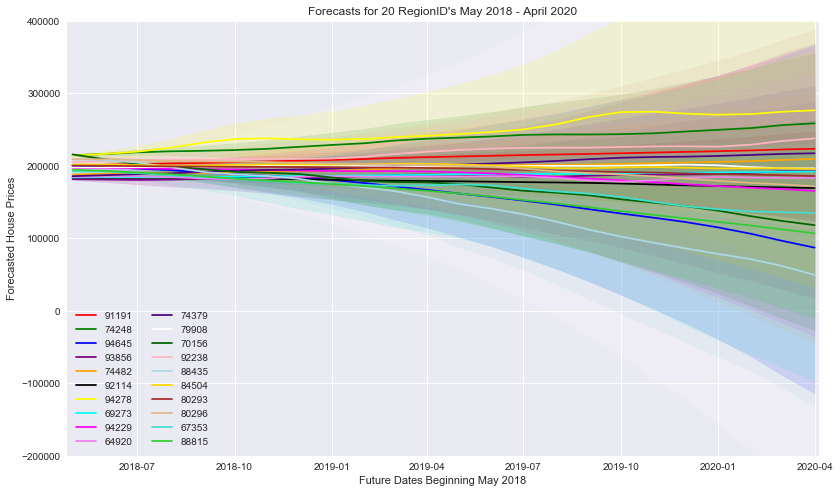

In [27]:
#creating a graph of the predictions
fig = plt.figure(figsize = (12, 8))

for regid,colo in zip(listofids,colors):
    plt.plot(confidf['forecast '+str(regid)], label = str(regid), color=colo)
    plt.fill_between(confidf.index, confidf['lower '+str(regid)], confidf['upper '+str(regid)], color=colo, alpha=.15)#, label = str(regid)+' confidence interval')

plt.legend(loc="lower left",ncol=2)
plt.ylim(bottom=-200000)
plt.ylim(top=400000)
plt.xlim(left=736809.95)#if 736779.95 is a little before 2018-05, then adding 30 would almost put the beginning on the y-axis
plt.xlim(right=737520.05)#similar to above for 2020-04
plt.title("Forecasts for 20 RegionID's May 2018 - April 2020")
plt.ylabel("Forecasted House Prices")
plt.xlabel("Future Dates Beginning May 2018")
plt.savefig("files/20 RegionID Forecasts.png")
plt.show()

Now creating another graph with only the five best RegionID's data, predictions (and confidence intervals) for the presentation.

In [13]:
best5info

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
459,74379,37421,Chattanooga,TN,Chattanooga,Hamilton,460,102400.0,102400.0,102500.0,...,175300,176900,178600,179900,180800,181300,182000,182900,184000,184800
1185,91191,76017,Arlington,TX,Dallas-Fort Worth,Tarrant,1186,105400.0,105400.0,105500.0,...,188100,188900,189500,190700,192000,193300,194300,196000,198100,199400
2323,74248,37217,Nashville,TN,Nashville,Davidson,2324,96000.0,96200.0,96500.0,...,194000,195600,197000,198700,200500,202700,205000,207500,210700,213000
3626,92114,77833,Brenham,TX,Brenham,Washington,3627,88900.0,88900.0,88900.0,...,181400,182800,184200,184800,184500,184100,184000,183500,183200,183300
6307,69273,27282,High Point,NC,NaN,Guilford,6308,129800.0,129400.0,129000.0,...,180000,179600,179400,180000,180600,181100,181500,182200,182800,183300


In [34]:
#convert the top 5 into a transposed dataframe of only the prices and dates
best5df = transposeDF(best5info)
best5df.head()

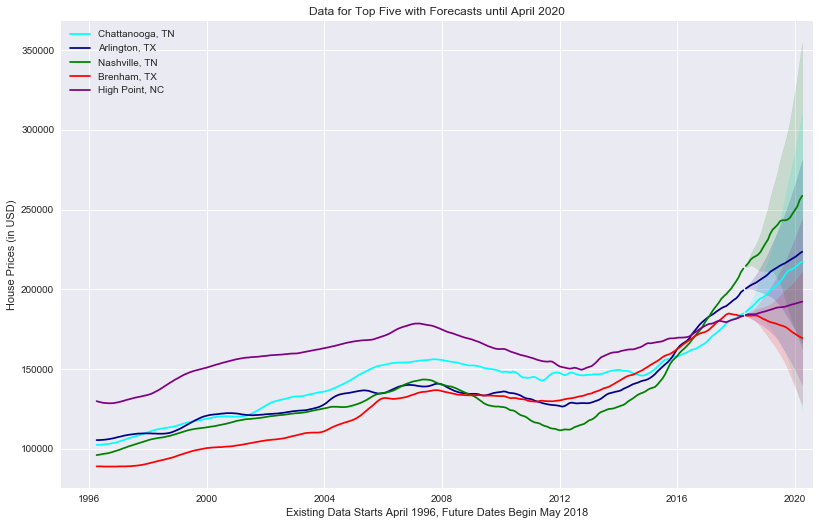

In [48]:
colors = ["cyan","darkblue","green","red","purple"]
fig = plt.figure(figsize = (12, 8))

for regid,colo,idx in zip(best5info.RegionID,colors,best5info.index):
    plt.plot(best5df[regid], label = f"{best5info.City[idx]}, {best5info.State[idx]}", color=colo)
    plt.plot(confidf['forecast '+str(regid)], label="_", color=colo)#setting label to _ makes it not show in the legend
    plt.fill_between(confidf.index, confidf['lower '+str(regid)], confidf['upper '+str(regid)], color=colo, alpha=.15)#, label = str(regid)+' confidence interval')

plt.legend(loc="upper left")
plt.xlim(right=737650.05)#similar to previous graph; finding the correct spot to end the plot to work with the space
plt.title("Data for Top Five with Forecasts until April 2020")
plt.ylabel("House Prices (in USD)")
plt.xlabel("Existing Data Starts April 1996, Future Dates Begin May 2018")
plt.savefig("files/TopFiveDataandForecasts.png")
plt.show()

## Reviewing Expected Percent Change

In [102]:
#checking listofdfs is what I expect
listofdfs[0].head()

,lower 91191,upper 91191,forecast 91191
2018-05-01,199982.784448,200988.789063,200485.786755
2018-06-01,200243.256599,202764.828513,201504.042556
2018-07-01,200245.874578,204730.046484,202487.960531
2018-08-01,199919.685172,206733.715816,203326.700494
2018-09-01,199287.831224,208747.232059,204017.531641


In [103]:
listofdfs[1].tail()

,lower 74248,upper 74248,forecast 74248
2019-12-01,179624.167494,315009.325189,247316.746342
2020-01-01,175229.615688,324110.416132,249670.015910
2020-02-01,170634.652162,333536.700412,252085.676287
2020-03-01,167399.598465,344822.353330,256110.975898
2020-04-01,162443.130247,354863.768097,258653.449172


In [8]:
#resuming with forecast20df
forecast20df = pd.read_csv("files/pred20.csv")
forecast20df.head()

,times,91191,74248,94645,93856,74482,92114,94278,69273,94229,...,74379,79908,70156,92238,88435,84504,80293,80296,67353,88815
0,2018-04-01,199400.000000,213000.000000,202100.000000,181500.00000,186700.000000,183300.00000,211800.000000,183300.000000,196500.000000,...,184800.000000,196900.000000,218500.000000,203900.00000,211400.00000,202000.000000,200200.000000,208500.000000,190500.000000,195200.000000
1,2020-04-01,165918.049134,162443.130247,-114363.068525,16844.03922,118535.461398,127682.84529,48736.716916,140302.529452,-35228.547763,...,124216.102983,-266194.382414,-26592.766214,113550.76803,-131046.19182,32223.426803,124417.127534,-44829.970669,-96681.641205,-9751.516163


In [9]:
#changing the read .CSV file to have more descriptive row names
forecast20df.times = ["Last Record", "Last Lower"]
forecast20df.set_index("times",inplace=True)
forecast20df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, Last Record to Last Lower
Data columns (total 20 columns):
91191    2 non-null float64
74248    2 non-null float64
94645    2 non-null float64
93856    2 non-null float64
74482    2 non-null float64
92114    2 non-null float64
94278    2 non-null float64
69273    2 non-null float64
94229    2 non-null float64
64920    2 non-null float64
74379    2 non-null float64
79908    2 non-null float64
70156    2 non-null float64
92238    2 non-null float64
88435    2 non-null float64
84504    2 non-null float64
80293    2 non-null float64
80296    2 non-null float64
67353    2 non-null float64
88815    2 non-null float64
dtypes: float64(20)
memory usage: 336.0+ bytes


In [9]:
#I have found it easier to add columns to a dataframe than rows so I will transpose it before doing some calculations
fore20df = forecast20df.T
fore20df["RegionID"]=fore20df.index #adding the RegionID as a column
fore20df.head()

times,Last Record,Last Lower,RegionID
91191,199400.0,165918.049134,91191
74248,213000.0,162443.130247,74248
94645,202100.0,-114363.068525,94645
93856,181500.0,16844.039220,93856
74482,186700.0,118535.461398,74482


In [10]:
#adding the change as a percentage of the original value
fore20df["Percent Change"] = [(p-r)/r*100 for r, p in zip(fore20df.loc[:,"Last Record"],fore20df.loc[:,"Last Lower"])]
fore20df.head()

times,Last Record,Last Lower,RegionID,Percent Change
91191,199400.0,165918.049134,91191,-16.791349
74248,213000.0,162443.130247,74248,-23.735620
94645,202100.0,-114363.068525,94645,-156.587367
93856,181500.0,16844.039220,93856,-90.719538
74482,186700.0,118535.461398,74482,-36.510197


In [11]:
#getting the five records with the highest percent change
bestfive = fore20df.sort_values(by="Percent Change").tail()

In [12]:
bestfive

times,Last Record,Last Lower,RegionID,Percent Change
74379,184800.0,124216.102983,74379,-32.783494
92114,183300.0,127682.845290,92114,-30.342147
74248,213000.0,162443.130247,74248,-23.735620
69273,183300.0,140302.529452,69273,-23.457431
91191,199400.0,165918.049134,91191,-16.791349


Although the percent change values are all negative, they are the most accurate predictions with this methodology, as they had the smallest mean-squared error.  At worst, they will still lose the investor a smaller amount of money than other RegionID's.

The best five RegionID's to invest in are the following, as they are most likely to lose the least amount of value over the two-year period of April 2018 to April 2020: 74379, 92114, 74248, 69273, and 91191.

# Step 6: Summarizing results and looking back to the original data

In [133]:
#For completeness' sake, I will pull these records from the original zillow_data
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [134]:
data.RegionID.dtype

dtype('int64')

In [12]:
#since I know the RegionID is a column of integers, I don't need to compare the values as strings
best5info = data[data.RegionID.isin([74379, 92114, 74248, 69273, 91191])]
best5info

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
459,74379,37421,Chattanooga,TN,Chattanooga,Hamilton,460,102400.0,102400.0,102500.0,...,175300,176900,178600,179900,180800,181300,182000,182900,184000,184800
1185,91191,76017,Arlington,TX,Dallas-Fort Worth,Tarrant,1186,105400.0,105400.0,105500.0,...,188100,188900,189500,190700,192000,193300,194300,196000,198100,199400
2323,74248,37217,Nashville,TN,Nashville,Davidson,2324,96000.0,96200.0,96500.0,...,194000,195600,197000,198700,200500,202700,205000,207500,210700,213000
3626,92114,77833,Brenham,TX,Brenham,Washington,3627,88900.0,88900.0,88900.0,...,181400,182800,184200,184800,184500,184100,184000,183500,183200,183300
6307,69273,27282,High Point,NC,NaN,Guilford,6308,129800.0,129400.0,129000.0,...,180000,179600,179400,180000,180600,181100,181500,182200,182800,183300


Interestingly, two of them are in Texas and two in Tennessee, with the remaining one in North Carolina.

The final ranking would be as follows:

In [167]:
regionids = [74379, 92114, 74248, 69273, 91191]
for idx,each in enumerate(regionids):
    row = best5info[best5info.RegionID==each]
    rank = 5-idx
    print(f"{rank}. {row.City.iloc[0]}, {row.State.iloc[0]}      RegionID: {each}, RegionName: {row.RegionName.iloc[0]}")

5. Chattanooga, TN      RegionID: 74379, RegionName: 37421
4. Brenham, TX      RegionID: 92114, RegionName: 77833
3. Nashville, TN      RegionID: 74248, RegionName: 37217
2. High Point, NC      RegionID: 69273, RegionName: 27282
1. Arlington, TX      RegionID: 91191, RegionName: 76017


## To Sum Up:
Of the median ninth of the dataset, the best places in which to invest are the five listed above, as in a worst-case scenario, they are the most certain to lose the least amount of money.  Time was a large factor in this analysis.  If you get shorter or longer times for the one-column analyses I had set up, you can then get a sense for how long it could take to run the loops over every column.

Since these are the best of the median, the best places that are closest to the average over the entire time period may be different and more closely match the model, since it was made with `avgtseries`.